# Factor Analysis of Horse-Rider Dyad Performance in Show Jumping
This notebook examines the FEI (the international governing body in equestrian sport) Combination in Jumping rankings (the rankings of horse and rider pairs) and attempts to predict them based on data publicly available on the FEI website. Several models are fitted using both a priori and a posteriori information and then the feature importance is evaluated to determine which factors contribute most to the predicted rankings. Some models are fitted using only a priori information to determine the predictability of rankings beforehand, but others use information available only after competitions are completed in order to determine patterns or strategies relating to the successful combinations.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress
from datetime import datetime
import shap

study_date = datetime(2023, 9, 1)

## To do 
# jumping elo, fix pie chart, more robust classification of classes

# Data Loading

## Combination in Jumping Rankings

In [2]:
rankings = pd.read_csv('/kaggle/input/fei-combination-rankings/feiid.csv', encoding='latin-1')
rankings

Rank  Previous  Rider ID                     Athlete Horse ID  \
0        1       1.0  10001601       VON ECKERMANN, Henrik  105PY55   
1        2       2.0  10001850           EPAILLARD, Julien  107GF73   
2        3       3.0  10009302            FARRINGTON, Kent  106IB26   
3        3       5.0  10001566            SMOLDERS, Harrie  105LH22   
4        5       4.0  10002790             DELESTRE, Simon  106JR76   
...    ...       ...       ...                         ...      ...   
5356  5330    4936.0  10000859              RAYMONT, Billy  108IT60   
5357  5330    4936.0  10000859              RAYMONT, Billy  107GV28   
5358  5330       NaN  10004039                 SATO, Eiken  107BA80   
5359  5330    4936.0  10068527  VAN DER MERWE, Christopher  105WD92   
5360  5330    4936.0  10097867              VESTJENS, Teun  108IH78   

                       Horse   NF  Points  
0                KING EDWARD  SWE  1223.0  
1           DONATELLO D'AUGE  FRA  1113.0  
2                     LANDON  USA  1092.0  
3              MONACO N.O.P.  NED  1092.0  
4          DEXTER FONTENIS Z  FRA  1036.0  
...                      ...  ...     ...  
5356  BELTANA QUINTESSENTIAL  AUS     1.0  
5357        YIRRKALA CAMERON  AUS     1.0  
5358              CORBLUE PS  JPN     1.0  
5359            ELIJNN RBF Z  RSA     1.0  
5360                VALIENTE  NED     1.0  

[5361 rows x 8 columns]

In [3]:
for col in rankings.columns:
    print(col)
    print(rankings[col].describe(), '\n')

Rank
count    5361.000000
mean     2569.131878
std      1442.717880
min         1.000000
25%      1336.000000
50%      2625.000000
75%      3854.000000
max      5330.000000
Name: Rank, dtype: float64 

Previous
count    4958.000000
mean     2372.384833
std      1331.903202
min         1.000000
25%      1218.000000
50%      2358.000000
75%      3522.000000
max      4936.000000
Name: Previous, dtype: float64 

Rider ID
count    5.361000e+03
mean     1.006264e+07
std      5.970650e+04
min      1.000018e+07
25%      1.001173e+07
50%      1.004327e+07
75%      1.009860e+07
max      1.032307e+07
Name: Rider ID, dtype: float64 

Athlete
count               5361
unique              2777
top       KENNY, Darragh
freq                  12
Name: Athlete, dtype: object 

Horse ID
count        5358
unique       5175
top       105UK71
freq            3
Name: Horse ID, dtype: object 

Horse
count       5358
unique      5135
top       HUNTER
freq           4
Name: Horse, dtype: object 

NF
count     53

## Athlete Details

In [4]:
athlete_details = pd.read_json('/kaggle/input/fei-data/FEIDatabase.athlete_details.json').drop_duplicates('fei_id').set_index('fei_id')
athlete_details
athlete_details['Age'] = (study_date - pd.to_datetime(athlete_details['Date of birth'])).dt.days.astype(float)

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


## Athlete Performance

In [5]:
athlete_per = pd.read_json('/kaggle/input/fei-data/FEIDatabase.athlete_performance.json').drop_duplicates('fei_id').set_index('fei_id')
athlete_per

_id                     Name  \
fei_id                                                                    
10001601  {'$oid': '64fca33638e0db5383956fbe'}    VON ECKERMANN, Henrik   
10001850  {'$oid': '64fca34d38e0db5383956fbf'}        EPAILLARD, Julien   
10009302  {'$oid': '64fca35d38e0db5383956fc0'}         FARRINGTON, Kent   
10001566  {'$oid': '64fca37338e0db5383956fc1'}         SMOLDERS, Harrie   
10002790  {'$oid': '64fca38538e0db5383956fc2'}          DELESTRE, Simon   
...                                        ...                      ...   
10087610  {'$oid': '64fd5779c50c9b968a7d861f'}  GUTIERREZ DIAZ, Alfonso   
10029915  {'$oid': '64fd5784c50c9b968a7d8620'}       CORRIGAN, Jonathan   
10080531  {'$oid': '64fd578fc50c9b968a7d8621'}     ROHDE, Karen Moeller   
10109301  {'$oid': '64fd5798c50c9b968a7d8622'}       KASOWITZ, Samantha   
10045986  {'$oid': '64fd57a3c50c9b968a7d8623'}      KAISER, Detlef Jun.   

          Gender                   Competing for  \
fei_id                                             
10001601    Male                    SWE - Sweden   
10001850    Male                    FRA - France   
10009302    Male  USA - United States of America   
10001566    Male               NED - Netherlands   
10002790    Male                    FRA - France   
...          ...                             ...   
10087610    Male                    MEX - Mexico   
10029915    Male                   IRL - Ireland   
10080531  Female                   DEN - Denmark   
10109301  Female  USA - United States of America   
10045986    Male                   GER - Germany   

                                                     Horses  Number of horses  \
fei_id                                                                          
10001601  [A BERNHARD, ADAMAS, AK’S CLOWNEY, AKTEUR 119,...               119   
10001850  [A  VIE DU CALVAIRE, AFERCO, ALCO, ALIBI DE LA...               119   
10009302  [AMBLER GAMBLER, ARON S, AUSTRIA 2, BALTIC STA...                55   
10001566  [ACORTE, ADAMO VAN 'T STEENPUTJE, AIYETORO, AL...               102   
10002790  [AKINA 23, ALITA DES ISLES, ARMANI V OVERIS Z,...                97   
...                                                     ...               ...   
10087610  [ARINA, ARMENTOS, CORBI, FERNANDO BLUE, JALLAS...                10   
10029915  [AUDI 'S DIMPLE, CARLINA, DARIUS DE KERGLENN, ...                19   
10080531  [ALTHEA NOVA ASK, BE COOL DE BARCENAL Z, BIRKE...                48   
10109301  [ASTORIA JO, CHARLIE, CORPRIZIA, G ANDIAMO ROD...                 6   
10045986  [ASCA BLUE HELDENLAAN Z, CANTURANA 5, CAROLUS ...                43   

          num_competitions                                     Current horses  \
fei_id                                                                          
10001601              3053  [CALIZI, DZARA DORCHIVAL, FUFU Z, GLAMOUR GIRL...   
10001850              3986  [ALIBI DE LA ROQUE, ARKA DE LA HART Z, BLACK S...   
10009302              2215  [CREEDANCE, DAGNY, ELECTRIQUE, GREYA, LANDON, ...   
10001566              3433  [BINGO DU PARC, CONTHAGNIA BLUE, DARRY LOU, DE...   
10002790              3353  [CALL ME BLUE, CAYMAN JOLLY JUMPER, DEXTER FON...   
...                    ...                                                ...   
10087610               238                               [JALLAS K, QATAR LS]   
10029915               374  [DARIUS DE KERGLENN, JARMENSINA VDM, NADAL VD ...   
10080531               699  [CASSADO ASK, DAVOS ASK Z, EVOLUTION ASK DWB, ...   
10109301               110                          [ASTORIA JO, NABABETTE Z]   
10045986               319  [CHELSEA 187, CLASALL, CORNETTA VD HORST Z, HA...   

                                          Current horse ids  \
fei_id                                                        
10001601  [107FI41, 106UA85, 107VC73, 105UM04, 106PE00, ...   
10001850  [104YE61, 105EH81, 105SB54, 106GQ90, 106QL29, ...   
10009302  [104NA62, 107EW40, 1

## Horse Details

In [6]:
def standardize_breed(breed):
    if type(breed) == float:
        if np.isnan(breed):
            return "Unknown"
    breed = str(breed).lower()
    breeds = {'Belgian Warmblood': ['belgien', 'belgish walmbloedpaard - bwp', 'belgium', 'belgisches warmblutpferd', 'belgian sporthorse', 'bwp', 'belgish warmblood - bwp', 'belgisch warmbloedpaard', 'belgian warmblood', 'belgisches wb', 'cheval de sport belge', 'belgisches warmblut sbs', 'belgium ?watmblood', 'belgish warmbloed', 'belgish walmbloedpaard - sbs', 'belgian sport horse', 'belgisch wb', 'belgisches warmblut - bwp', 'belgium warmblood', 'belgisch warmbloedpaard - bwp', 'belgish warmblood - sbs', 'sbs', 'bel_'], 
             'Selle Francais': ['cheval de selle francais', 'selle francais', 'selle francais section a', 'france', 'selle france', 'selle francaise', 'sf', 'selle français', 'selle francias', 'cheval de selle', 'selle francais section b', 'selle fran'], 
             'Holsteiner': ['holsteiner warmblut', 'holsteiner', 'holst', 'holsteiner warmblutt', 'holsteiner warmblood', 'hol', 'holstiener', 'holsteiner x', 'hols'], 
             'Estonian Sport Horse': ['estland sportpferd', 'estonian sport horse'], 
             'Oldenburg': ['oldenburger springferd', 'oldenbg. springpferd', 'oldenburger springfeld', 'oldenburger', 'oldb', 'olenburger springpferd', 'oldsp', 'os', 'oldbg', 'oldenburg', 'oldenburger springpferd', 'old', 'oldenburger springpferde'], 
             'Zangersheide': ['zangersheide', 'zangersheider', 'zangersheider warmblood', 'zang', 'zangersheider reitpferd', 'zangerseheide', 'zangersheide reitpferd', 'zangerheide', 'z', 'zh'],
             'Dutch Warmblood': ['deutsches sportpferd', 'kwpn', 'dutch warmblood', 'na dutch warmblood', 'dutch warmblod', 'kon. warm paard nederland'],
             'Westphalian': ['westfale', 'westfalen', 'westphalian', 'westf', 'westfalisches reitpferd', 'west', 'westfälisches reitpferd', 'westfahler', 'westalen'], 
             'Brazilian Sport Horse': ['brazillian sport horse', 'brasileiro de hipismo'],
             'Unknown': ['', "breeder's name"], 
             'Irish Sport Horse': ['ish', 'irish sport horse', 'irl', 'irish horse register'],
             'Hanoverian': ['hanoverian', 'hannoveraner', 'hann', 'hannover', 'hannoverian', 'hanovarian'],
             'Swiss Warmblood': ['schweizer warmblut', 'cheval suisse', 'cheval de selle suisse', 'suisse', 'ch-swiss warmblood', 'swiss warmblood'],
             'Swedish Warmblood': ['swb', 'swedish warmblood'],
             'German Sport Horse': ['dsp', 'german sporthorse'],
             'Spanish Sport Horse': ['sp', 'spanish sporthorse'],
             'Latvian Warmblood': ['lwb'],
             'New Zealand Warmblood': ['nz warmblood', 'nz hanoverian'],
             'AES': ['aes', 'anglo european studbook', 'anglo european', 'aes - anglo european studbook'],
             'Mecklenburg': ['mecklenburg', 'mecklenburg vorpommern', 'mecklenburger', 'zangersheider warmblut', 'meckl'],
             'ZFDP': ['zfdp'],    
             'Warmblood x Thoroughbred': ['tb x warmblood', 'warmblood x thoroughbred'],
             'Warmblood': ['warmblood', 'wb'], 
             'Danish Warmblood': ['dansk varmblod', 'danish warmblood', 'daenish warmblood'],
              'Bavarian Warmblood': ['bayer', 'bayerisches wb'],
              'Austrian Warmblood': ['österreich warmblut', 'öster. warmblut', 'österreichisches warmblut', 'aust. warmblood'],
              'Anglo-Arab': ['anglo-arabe']
              

            }
    
    for k, v in breeds.items():
        if breed in v:
            return k
            
    else:
        return breed  # 'Other'  



def standardize_breeder(breeder):
    if type(breeder) == float:
        if np.isnan(breeder):
            return "Unknown"
    breeder = str(breeder).lower()
    breeders = {'Belgian Warmblood': ['belgien', 'belgish walmbloedpaard - bwp', 'belgium', 'belgisches warmblutpferd', 'belgian sporthorse', 'bwp', 'belgish warmblood - bwp', 'belgisch warmbloedpaard', 'belgian warmblood', 'belgisches wb', 'cheval de sport belge', 'belgisches warmblut sbs', 'belgium ?watmblood', 'belgish warmbloed', 'belgish walmbloedpaard - sbs', 'belgian sport horse', 'belgisch wb', 'belgisches warmblut - bwp', 'belgium warmblood', 'belgisch warmbloedpaard - bwp', 'belgish warmblood - sbs', 'sbs', 'bel_'], 
             'Selle Francais': ['cheval de selle francais', 'selle francais', 'selle francais section a', 'france', 'selle france', 'selle francaise', 'sf', 'selle français', 'selle francias', 'cheval de selle', 'selle francais section b', 'selle fran'], 
             'Holsteiner': ['holsteiner warmblut', 'holsteiner', 'holst', 'holsteiner warmblutt', 'holsteiner warmblood', 'hol', 'holstiener', 'holsteiner x', 'hols'], 
             'Estonian Sport Horse': ['estland sportpferd', 'estonian sport horse'], 
             'Oldenburg': ['oldenburger springferd', 'oldenbg. springpferd', 'oldenburger springfeld', 'oldenburger', 'oldb', 'olenburger springpferd', 'oldsp', 'os', 'oldbg', 'oldenburg', 'oldenburger springpferd', 'old', 'oldenburger springpferde'], 
             'Zangersheide': ['zangersheide', 'zangersheider', 'zangersheider warmblood', 'zang', 'zangersheider reitpferd', 'zangerseheide', 'zangersheide reitpferd', 'zangerheide', 'z', 'zh'],
             'Dutch Warmblood': ['deutsches sportpferd', 'kwpn', 'dutch warmblood', 'na dutch warmblood', 'dutch warmblod', 'kon. warm paard nederland'],
             'Westphalian': ['westfale', 'westfalen', 'westphalian', 'westf', 'westfalisches reitpferd', 'west', 'westfälisches reitpferd', 'westfahler', 'westalen'], 
             'Brazilian Sport Horse': ['brazillian sport horse', 'brasileiro de hipismo'],
             'Unknown': ['', "breeder's name"], 
             'Irish Sport Horse': ['ish', 'irish sport horse', 'irl', 'irish horse register'],
             'Hanoverian': ['hanoverian', 'hannoveraner', 'hann', 'hannover', 'hannoverian', 'hanovarian'],
             'Swiss Warmblood': ['schweizer warmblut', 'cheval suisse', 'cheval de selle suisse', 'suisse', 'ch-swiss warmblood', 'swiss warmblood'],
             'Swedish Warmblood': ['swb', 'swedish warmblood'],
             'German Sport Horse': ['dsp', 'german sporthorse'],
             'Spanish Sport Horse': ['sp', 'spanish sporthorse'],
             'Latvian Warmblood': ['lwb'],
             'New Zealand Warmblood': ['nz warmblood', 'nz hanoverian'],
             'AES': ['aes', 'anglo european studbook', 'anglo european', 'aes - anglo european studbook'],
             'Mecklenburg': ['mecklenburg', 'mecklenburg vorpommern', 'mecklenburger', 'zangersheider warmblut', 'meckl'],
             'ZFDP': ['zfdp'],    
             'Warmblood x Thoroughbred': ['tb x warmblood', 'warmblood x thoroughbred'],
             'Warmblood': ['warmblood', 'wb'], 
             'Danish Warmblood': ['dansk varmblod', 'danish warmblood', 'daenish warmblood'],
              'Bavarian Warmblood': ['bayer', 'bayerisches wb'],
              'Austrian Warmblood': ['österreich warmblut', 'öster. warmblut', 'österreichisches warmblut', 'aust. warmblood'],
              'Anglo-Arab': ['anglo-arabe']
              

            }
    
    for k, v in breeders.items():
        if breeder in v:
            return k
            
    else:
        return breeder

In [7]:
horse_details = pd.read_json('/kaggle/input/fei-data/FEIDatabase.horse_details.json').drop_duplicates('fei_id').set_index('fei_id')
breeders = []

# change the breeder data from list to str
for b in horse_details['Breeder']:
    if len(b) > 0 and type(b) == list:
        b = b[0]
    elif type(b) == list:
        b = ''
    breeders.append(b)
horse_details['Breeder'] = breeders
horse_details['Breed'] = horse_details['Breed'].apply(standardize_breed)
horse_details       

_id              Birth Name  \
fei_id                                                                  
105PY55  {'$oid': '64fca258d275c433503dea0e'}        KING EDWARD RESS   
107GF73  {'$oid': '64fca264d275c433503dea0f'}        DONATELLO D'AUGE   
106IB26  {'$oid': '64fca272d275c433503dea10'}         CRACK DE NYZE Z   
105LH22  {'$oid': '64fca27cd275c433503dea11'}                  MONACO   
107CC83  {'$oid': '64fca292d275c433503dea12'}         CEPANO BALOUBET   
...                                       ...                     ...   
107KU35  {'$oid': '64fdaaf9eb61e7b14c8ec04b'}                   IMOLA   
106EE45  {'$oid': '64fdab04eb61e7b14c8ec04c'}             ALPHAJET DB   
106DZ74  {'$oid': '64fdab1aeb61e7b14c8ec04d'}           SINGAPORE PKZ   
105YI36  {'$oid': '64fdab56eb61e7b14c8ec04e'}              IL DIVO BS   
106TM06  {'$oid': '64fdab77eb61e7b14c8ec04f'}  OLGA VAN DE KRUISHOEVE   

                   Current Name  Status Last Change Date of Birth  Gender  \
fei_id                                                                      
105PY55             KING EDWARD  Active  27/02/2019    21/05/2010    Male   
107GF73        DONATELLO D'AUGE  Active  18/05/2021    13/05/2013    Male   
106IB26                  LANDON  Active  25/05/2021    24/05/2013    Male   
105LH22                  MONACO  Active  05/08/2022    30/03/2009    Male   
107CC83         CEPANO BALOUBET  Active  19/01/2021    03/05/2014    Male   
...                         ...     ...         ...           ...     ...   
107KU35                   IMOLA  Active  14/09/2021    10/04/2013    Male   
106EE45             ALPHAJET DB  Active  30/07/2018    10/04/2011    Male   
106DZ74           SINGAPORE PKZ  Active  23/07/2018    05/06/2012    Male   
105YI36              IL DIVO BS  Active  14/02/2018    28/03/2013    Male   
106TM06  OLGA VAN DE KRUISHOEVE  Active  21/01/2020    21/06/2014  Female   

        Castrated/Sterilized              Breed                 Sire  ...  \
fei_id                                                                ...   
105PY55                  Yes  Belgian Warmblood            EDWARD 28  ...   
107GF73                  Yes     Selle Francais               JARNAC  ...   
106IB26                  Yes       Zangersheide       Comilfo Plus Z  ...   
105LH22                  Yes         Holsteiner           CASSINI II  ...   
107CC83                  Yes    Dutch Warmblood               CHAMAN  ...   
...                      ...                ...                  ...  ...   
107KU35                  Yes            Unknown               KANNAN  ...   
106EE45                  Yes        Westphalian             ARPEGGIO  ...   
106DZ74                  Yes            Unknown                       ...   
105YI36                  Yes            Unknown  CLICK AND CASH 1155  ...   
106TM06              Unknown            Unknown                       ...   

                  Sire of Dam Dam's Sire's UELN Administering NF  \
fei_id                                                             
105PY55                   FEO                                SWE   
107GF73       HELLO PIERVILLE   25000195488394R              FRA   
106IB26             Quadrillo                                USA   
105LH22             CONTENDER   276321210023884              USA   
107CC83  STAKKATO'S HIGHLIGHT   276431312336401              GER   
...                       ...               ...              ...   
107KU35            SILVERSTAR                                NED   
106EE45      CORNET OBOLENSKY   056002W00184083              GER   
106DZ74                                                      GER   
105YI36           CONTENDRO I   276321210149897              SWE   
106TM06                                                      MAR   

             National ID Issuing NF Issuing Date Valid Until Pony  \
fei_id                                                              
105PY55           137788        SUI   26/02/2019  26/02/2027   No

In [8]:
# clean breeders that are not in a list
breeders = []


horse_details['Breed'] = [b if b != "Breeder's name" else '' for b in horse_details['Breed']]

print("Breeder\n", pd.Series([b for b in horse_details['Breeder'] if b != []]).describe())
print("\nBreed\n", pd.Series([b for b in horse_details['Breed'] if b != "Breeder's name"]).describe())
print("\nGender\n", horse_details['Gender'].describe())
print("\nCastrated/Sterilized\n", horse_details['Castrated/Sterilized'].describe())

Breeder
 count     4434
unique    3091
top           
freq       922
dtype: object

Breed
 count        4434
unique        154
top       Unknown
freq         1182
dtype: object

Gender
 count     4434
unique       2
top       Male
freq      2956
Name: Gender, dtype: object

Castrated/Sterilized
 count     4434
unique       3
top        Yes
freq      2013
Name: Castrated/Sterilized, dtype: object


## Horse Performance

In [9]:
horse_per = pd.read_json('/kaggle/input/fei-data/FEIDatabase.horse_performance.json').drop_duplicates('fei_id').set_index('fei_id')

In [10]:
horse_per['num_competitions'].describe()

count    4182.000000
mean      107.088235
std        70.748583
min         1.000000
25%        54.000000
50%        92.000000
75%       144.000000
max       488.000000
Name: num_competitions, dtype: float64

## Horse Pedigree

In [11]:
horse_ped = pd.read_json('/kaggle/input/fei-data/FEIDatabase.horse_pedigree.json').drop_duplicates('fei_id').set_index('fei_id')
horse_ped

_id  \
fei_id                                          
105PY55  {'$oid': '64fca27c8b4468e731602926'}   
107GF73  {'$oid': '64fca2858b4468e731602927'}   
106IB26  {'$oid': '64fca28e8b4468e731602928'}   
105LH22  {'$oid': '64fca29a8b4468e731602929'}   
106JR76  {'$oid': '64fca2ab8b4468e73160292a'}   
...                                       ...   
106XI27  {'$oid': '64fdaafd8b4468e731603c9d'}   
103RB62  {'$oid': '64fdab208b4468e731603c9e'}   
107HF06  {'$oid': '64fdab3e8b4468e731603c9f'}   
107FH46  {'$oid': '64fdab718b4468e731603ca0'}   
107ES39  {'$oid': '64fdab8c8b4468e731603ca1'}   

                                                  pedigree  
fei_id                                                      
105PY55  {'IsFirstHorsePedigree': True, 'IsPresent': Tr...  
107GF73  {'IsFirstHorsePedigree': True, 'IsPresent': Tr...  
106IB26  {'IsFirstHorsePedigree': True, 'IsPresent': Tr...  
105LH22  {'IsFirstHorsePedigree': True, 'IsPresent': Tr...  
106JR76  {'IsFirstHorsePedigree': True, 'IsPresent': Tr...  
...                                                    ...  
106XI27  {'IsFirstHorsePedigree': True, 'IsPresent': Tr...  
103RB62  {'IsFirstHorsePedigree': True, 'IsPresent': Tr...  
107HF06  {'IsFirstHorsePedigree': True, 'IsPresent': Tr...  
107FH46  {'IsFirstHorsePedigree': True, 'IsPresent': Tr...  
107ES39  {'IsFirstHorsePedigree': True, 'IsPresent': Tr...  

[4827 rows x 2 columns]

# Feature Construction

In [12]:

def count_items(l):
    """
    Finds the unique items in a list and counts their occurrences
    """
    counts = dict()
    for i in l:
        counts[i] = counts.get(i, 0) + 1
    return counts


def get_score(c):
    """
    Parses the score of the of the class into a list.
    Due to the large number of jumper tables with different scoring, this standardizes scoring with a round 1 faults and time 
    and jumpoff faults and time. Nonexistent values will be labeled NaN
    """
    s = c["Score"].split('/')  # takes the form faults/time if not in jump-off else faults/jo faults/jo time or faults/time/jo faults/jo time
    
    if len(s) == 2:
        r1_faults = s[0]
        r1_time = s[1]
        jo_faults = np.nan
        jo_time = np.nan
        
    elif len(s) == 3:
        r1_faults = s[0]
        r1_time = np.nan
        jo_faults = s[1]
        jo_time = s[2]
        
    elif len(s) == 4:
        r1_faults = s[0]
        r1_time = s[1]
        jo_faults = s[2]
        jo_time = s[3]
        
    elif len(s) == 1:
        r1_faults = np.nan
        r1_time = s[0]
        jo_faults = np.nan
        jo_time = np.nan
        
    elif len(s) == 6:  # change this
        r1_faults = s[0]
        r1_time = s[1]
        jo_faults = s[2]
        jo_time = s[3]
        
    else:
#         print(c)
        pass
        
    return r1_faults, r1_time, jo_faults, jo_time


def filter_scores(scores):
    new_scores = []
    ret_el = []
    for s in scores:
        
        try:
            
            s = float(s)
            if np.isnan(s):
                continue
            new_scores.append(s)
        except ValueError:
            ret_el.append(s)
    return new_scores, ret_el
            

def mean(l):
    try:
        return sum(l)/len(l)
    except ZeroDivisionError:
        return np.nan

            
def calc_score_metrics(classes):
    
    r1_faults = []
    r1_time = []
    jo_faults = []
    jo_time = []
    break_time = []
    
    date = None
    for c in classes:
        try:
            if date is None:
                date = datetime.strptime(c['Start Date'][:10],'%d/%m/%Y')
            else:
                new_date = datetime.strptime(c['Start Date'][:10],'%d/%m/%Y')
                bt = date - new_date
                date = new_date
                break_time.append(int(bt.days))

            r1f, r1t, jof, jot = get_score(c)
            r1_faults.append(r1f)
            r1_time.append(r1t)
            jo_faults.append(jof)
            jo_time.append(jot) 
        except Exception as e:
#             print(e)
            pass
    r1f, r1el_f = filter_scores(r1_faults)
    r1t, r1el_t = filter_scores(r1_time)
    jof, joel_f = filter_scores(jo_faults)
    jot, joel_t = filter_scores(jo_time)
    
    metrics = {'r1_mean_time': mean(r1t), 'r1_mean_faults': mean(r1f), 'jo_mean_time': mean(jot), 'jo_mean_faults': mean(jof), 
               'el_pct': len(r1el_f + r1el_t + joel_f + joel_t)/len(classes), 'break_time': mean(break_time), "std_break_time": np.array(break_time).std()}
    return metrics


def construct_score_df(performance_df):
    m = []
    try: 
        classes = performance_df['classes']
    except KeyError:
        classes = performance_df['Classes']
    for c, fei_id in zip(classes, performance_df.index):
        d = calc_score_metrics(c)
        d['fei_id'] = fei_id
        if 'Obst. Height' in pd.DataFrame(c).columns:
            heights = pd.to_numeric(pd.DataFrame(c)['Obst. Height'], errors='coerce').dropna()
            d['mean_height'] = heights.mean()
            d['pct_160'] = len(heights[heights>=160]/len(heights))
        m.append(d)
        c = pd.DataFrame(c)
    
    return pd.DataFrame(m).set_index('fei_id')


def construct_horse_detail_features(horse_details):
    
    horse_details['num_ownerships'] = horse_details['ownerships'].apply(len)

    return horse_details

    

In [13]:
def get_ped_data(horse_ped, relation=None):
    """
    Takes an individual horse from the pedigree and returns the
     'HorseFEIID'
     'CurrentName'
     'Sex'
     'Age',
     'Color'
    """
    d = {'HorseFEIID': '', 'CurrentName': '', 'Sex': '', 'Age': '', 'Color': '', 'ColorComplement': ''}
    for k in d.keys():
        d[k] = horse_ped[k]
    
    try:
        d['Age'] = int((datetime.today() - datetime.strptime(d['Age'][:10], '%d/%m/%Y')).days)
    except Exception as e:

        try:
            d['Age'] = (int(datetime.today().year) - int(d['Age'][:4])) * 365
        except:
            d['Age'] = np.nan
    
    if relation is not None:
        d = {relation+" "+k: v for k, v in d.items()}
    
    return d


def parse_pedigree(pedigree):
    """ 
    Number of generations
    Sire, Dame, Sire's Sire, Sire's Dam, Dam's Sire, Dam's Dam
    """
    horse = get_ped_data(pedigree)
    parents = pedigree["Parents"]
    for p in parents:
        if not p['IsPresent']:
            continue
        if p['Sex'] == "Mare":
            horse.update(get_ped_data(p, relation='Dam'))
            for p1 in p['Parents']:
                if p1['Sex'] == "Mare":
                    horse.update(get_ped_data(p1, relation="Dam's Dam"))
                else:
                    horse.update(get_ped_data(p1, relation="Dam's Sire"))
        else: # Stallion
            horse.update(get_ped_data(p, relation='Sire'))
            for p1 in p['Parents']:
                if p1['Sex'] == "Mare":
                    horse.update(get_ped_data(p1, relation="Sire's Dam"))
                else:
                    horse.update(get_ped_data(p1, relation="Sire's Sire"))
            
    return horse


def construct_pedigree_features(pedigree_df):
    peds = []
    for ped in pedigree_df['pedigree']:
        peds.append(parse_pedigree(ped))
        
    ped_df = pd.DataFrame(peds).set_index('HorseFEIID')
#     for col in ped_df.columns:
#         if type()
#         ped_df[col] = 
    return ped_df.groupby(ped_df.index).first()

In [14]:
ped_df = construct_pedigree_features(horse_ped)
det_df = construct_horse_detail_features(horse_details)
score_df = construct_score_df(horse_per)

horse_df = pd.concat([det_df, ped_df, rankings.drop_duplicates('Horse ID').set_index('Horse ID'), score_df, horse_per['num_competitions']], axis=1).sort_values(by='Rank').dropna(thresh=50).reset_index()
horse_df

Degrees of freedom <= 0 for slice
invalid value encountered in divide
invalid value encountered in double_scalars


index                                   _id         Birth Name  \
0     105PY55  {'$oid': '64fca258d275c433503dea0e'}   KING EDWARD RESS   
1     107GF73  {'$oid': '64fca264d275c433503dea0f'}   DONATELLO D'AUGE   
2     105LH22  {'$oid': '64fca27cd275c433503dea11'}             MONACO   
3     106JR76  {'$oid': '64fcadf6eb61e7b14c8eaf08'}  DEXTER FONTENIS Z   
4     107CC83  {'$oid': '64fca292d275c433503dea12'}    CEPANO BALOUBET   
...       ...                                   ...                ...   
3244  106HG24  {'$oid': '64fdaa87eb61e7b14c8ec046'}         DJANGO S 3   
3245  106CO70  {'$oid': '64fdaab1eb61e7b14c8ec048'}   GLOBAL CLOCKWISE   
3246  107LW41  {'$oid': '64fdaae9eb61e7b14c8ec04a'}           VANITY Z   
3247  107KU35  {'$oid': '64fdaaf9eb61e7b14c8ec04b'}              IMOLA   
3248  106EE45  {'$oid': '64fdab04eb61e7b14c8ec04c'}        ALPHAJET DB   

           Current Name  Status Last Change Date of Birth  Gender  \
0           KING EDWARD  Active  27/02/2019    21/05/2010    Male   
1      DONATELLO D'AUGE  Active  18/05/2021    13/05/2013    Male   
2                MONACO  Active  05/08/2022    30/03/2009    Male   
3     DEXTER FONTENIS Z  Active  06/03/2019    25/06/2013    Male   
4       CEPANO BALOUBET  Active  19/01/2021    03/05/2014    Male   
...                 ...     ...         ...           ...     ...   
3244         DJANGO S 3  Active  18/12/2018    02/04/2013    Male   
3245   GLOBAL CLOCKWISE  Active  06/06/2018    05/05/2012    Male   
3246           VANITY Z  Active  15/10/2021    30/05/2014  Female   
3247              IMOLA  Active  14/09/2021    10/04/2013    Male   
3248        ALPHAJET DB  Active  30/07/2018    10/04/2011    Male   

     Castrated/Sterilized              Breed  ... r1_mean_time r1_mean_faults  \
0                     Yes  Belgian Warmblood  ...    65.403500       3.565532   
1                     Yes     Selle Francais  ...    59.861351       3.020408   
2                     Yes         Holsteiner  ...    63.087000       2.533043   
3                     Yes       Zangersheide  ...    66.582105       3.773111   
4                     Yes    Dutch Warmblood  ...    65.325526       3.375000   
...                   ...                ...  ...          ...            ...   
3244                   No         Hanoverian  ...          NaN            NaN   
3245                  Yes         Hanoverian  ...          NaN            NaN   
3246              Unknown       Zangersheide  ...          NaN            NaN   
3247                  Yes            Unknown  ...          NaN            NaN   
3248                  Yes        Westphalian  ...          NaN            NaN   

     jo_mean_time jo_mean_faults el_pct break_time std_break_time mean_height  \
0       42.654615       0.615385   0.04   9.326531      11.029437       155.2   
1       38.311667       8.962500   0.04   5.857143       6.679240       150.7   
2       41.796875       1.625000   0.02   8.265306      13.352024       154.1   
3       43.740714      16.663125   0.16   7.571429       9.843676       155.9   
4       39.072381       2.333333   0.04   9.428571      18.718102       148.0   
...           ...            ...    ...        ...            ...         ...   
3244          NaN            NaN    NaN        NaN            NaN         NaN   
3245          NaN            NaN    NaN        NaN            NaN         NaN   
3246          NaN            NaN    NaN        NaN            NaN         NaN   
3247          NaN            NaN    NaN        NaN            NaN         NaN   
3248          NaN            NaN    NaN        NaN            NaN         NaN   

     pct_160 num_competitions  
0       30.0            188.0  
1       20.0            120.0  
2       27.0            264.0  
3       26.0            144.0  
4        7.0             86.0  
...      ...              ...  
3244     NaN              NaN  
3245     NaN              NaN  
3246     NaN              NaN  
3247     NaN            

<Axes: >

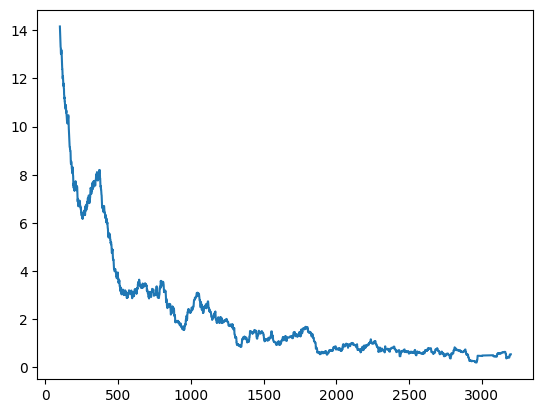

In [15]:
horse_df['pct_160'].dropna().rolling(100).mean().plot()

In [16]:
score_df = construct_score_df(athlete_per)
athlete_df = pd.concat([score_df, athlete_per, athlete_details, rankings.drop_duplicates('Rider ID').set_index('Rider ID')], axis=1).sort_values(by='Rank').dropna(thresh=20).reset_index()
athlete_df = athlete_df.loc[:,~athlete_df.columns.duplicated()].copy()
athlete_df

index  r1_mean_time  r1_mean_faults  jo_mean_time  jo_mean_faults  \
0     10001601     64.993590        2.014894     32.174000        1.200000   
1     10001850     63.098919        3.054375     34.651538        6.885000   
2     10009302     76.093529        4.562500     41.170000        6.608750   
3     10001566     68.457059        2.360652     37.762941        2.235294   
4     10002790     67.744419        3.517174     43.537692        8.650000   
...        ...           ...             ...           ...             ...   
2697  10033916     64.493953        4.958333     39.908125        1.812500   
2698  10028886     64.445882        8.842222     45.814000       11.600000   
2699  10028261     70.544444        7.255319     46.190000        2.714286   
2700  10119977     63.663714        3.473684     36.404615        6.923077   
2701  10114444     62.826250        3.936170     37.865000        5.869474   

        el_pct  break_time  std_break_time  mean_height  pct_160  ...  \
0     0.040000    1.714286        3.010187   150.918367     16.0  ...   
1     0.040000    1.306122        2.269623   146.836735     11.0  ...   
2     0.080000    1.612245        2.371741   145.000000      6.0  ...   
3     0.020000    0.877551        1.479557   147.282609     10.0  ...   
4     0.080000    1.897959        2.719881   155.408163     25.0  ...   
...        ...         ...             ...          ...      ...  ...   
2697  0.040000   80.346939      218.364940   136.333333      0.0  ...   
2698  0.107143  270.481481      743.667407   138.823529      0.0  ...   
2699  0.060000   80.489796      162.955124   145.925926      1.0  ...   
2700  0.240000   32.040816      108.714184   132.395833      0.0  ...   
2701  0.080000   10.897959       30.802362   133.900000      0.0  ...   

     registered_disciplines Date of birth      Age  Rank Previous  \
0                 [Jumping]    25/05/1981  15439.0     1      1.0   
1                 [Jumping]    24/07/1977  16840.0     2      2.0   
2                 [Jumping]    28/12/1980  15587.0     3      3.0   
3                 [Jumping]    10/05/1980  15819.0     3      5.0   
4                 [Jumping]    21/06/1981  15412.0     5      4.0   
...                     ...           ...      ...   ...      ...   
2697              [Jumping]    26/11/1990  11967.0  5330   4936.0   
2698              [Jumping]    05/02/1985  14087.0  5330      NaN   
2699              [Jumping]    10/06/1971  19076.0  5330   4936.0   
2700              [Jumping]    25/01/1982  15194.0  5330   4936.0   
2701              [Jumping]    24/02/2003   7494.0  5330   4936.0   

                            Athlete  Horse ID                  Horse   NF  \
0             VON ECKERMANN, Henrik   105PY55            KING EDWARD  SWE   
1                 EPAILLARD, Julien   107GF73       DONATELLO D'AUGE  FRA   
2                  FARRINGTON, Kent   106IB26                 LANDON  USA   
3                  SMOLDERS, Harrie   105LH22          MONACO N.O.P.  NED   
4                   DELESTRE, Simon   106JR76      DEXTER FONTENIS Z  FRA   
...                             ...       ...                    ...  ...   
2697                O'CONNOR, Kelly   104JD50                ILLIANO  RSA   
2698  BANCALARI ELMUDESI, Juan Jose   105IZ02  BALLYPATRICK FLAMENCO  DOM   
2699                 LANGLEY, Grant   106PS27      FORESYTE BENGSTON  RSA   
2700                MAHZOUN, Danial   106KW66            TIA MARIA Z  IRI   
2701              GREENLEES, Philip   106DG58           INO UNO D'OR  BRA   

      Points  
0     1223.0  
1     1113.0  
2     1092.0  
3     1092.0  
4     1036.0  
...      ...  
2697     1.0  
2698     1.0  
2699     1.0  
2700     1.0  
2701     1.0  

[2702 rows x 31 columns]

# Exploratory Data Analysis/Descriptive Statistics

## Combination in Jumping Rankings

Number of riders: 2777
Number of horses: 5136


The figure layout has changed to tight


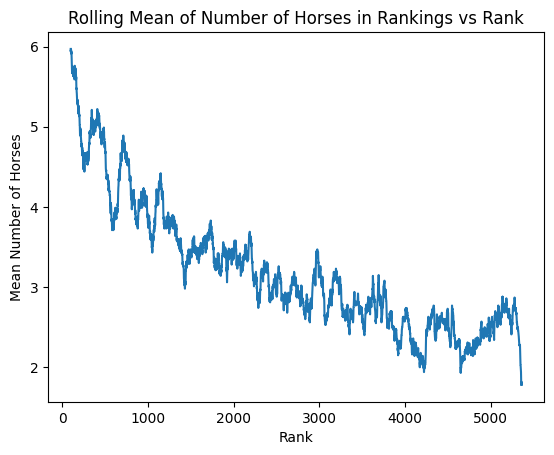

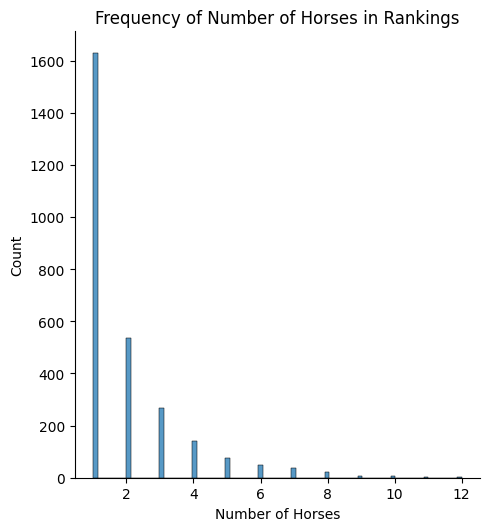

In [17]:
print("Number of riders:", len(rankings['Athlete'].unique()))
print("Number of horses:", len(rankings['Horse'].unique()))
counts = count_items(rankings['Athlete'])
    
num_horses = []
for a in rankings['Athlete']:
    num_horses.append(counts[a])
rankings["num_horses"] = num_horses
rankings["num_horses"].rolling(100).mean().plot(title="Rolling Mean of Number of Horses in Rankings vs Rank", xlabel="Rank", ylabel="Mean Number of Horses")

sns.displot(counts).set(title="Frequency of Number of Horses in Rankings", xlabel="Number of Horses");



## Athlete Details

<Axes: title={'center': 'Gender'}>

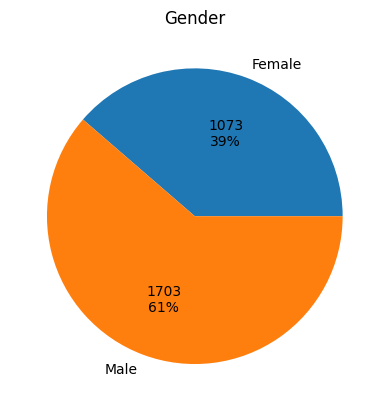

In [18]:

def label_function(val):
    return f'{val / 100 * len(athlete_details):.0f}\n{val:.0f}%'

athlete_details.groupby('Gender').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10}, title='Gender')


<Axes: title={'center': 'Athletes by Country'}>

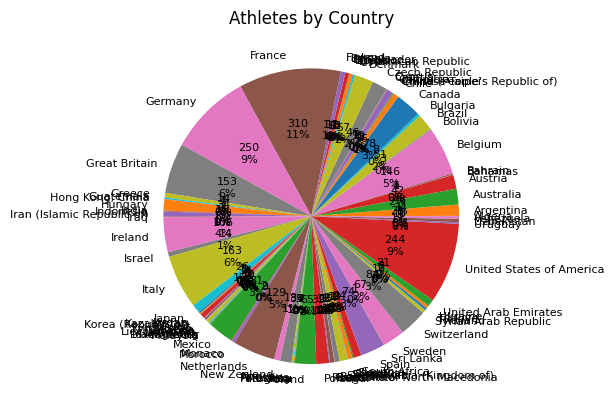

In [19]:
athlete_details.groupby('Competing for').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8}, title='Athletes by Country')

## Athlete Performance

### Number of Horses

The figure layout has changed to tight


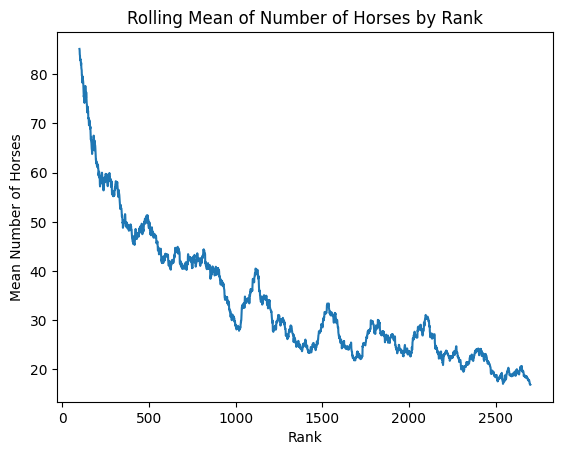

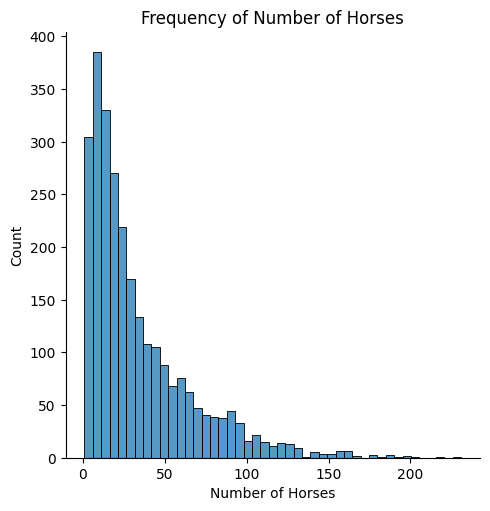

In [20]:
athlete_df["Number of horses"].rolling(100).mean().plot(title='Rolling Mean of Number of Horses by Rank', xlabel='Rank', ylabel='Mean Number of Horses')

sns.displot(athlete_df["Number of horses"]).set(title="Frequency of Number of Horses", xlabel="Number of Horses");

LinregressResult(slope=-9.713112290697614, intercept=1683.6216468372932, rvalue=-0.4059614240630058, pvalue=9.790261632287506e-108, stderr=0.42080974329159615, intercept_stderr=19.91189613392757)

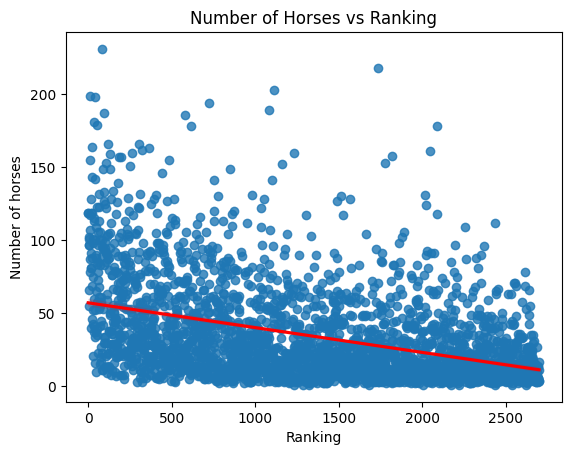

In [21]:
sns.regplot(x=athlete_df.index, y=athlete_df['Number of horses'], line_kws={'color': 'red'}).set(title="Number of Horses vs Ranking", xlabel='Ranking')
linregress(athlete_df['Number of horses'], athlete_df.index)

### Number of Horses in Rankings

In [22]:
athlete_df

index  r1_mean_time  r1_mean_faults  jo_mean_time  jo_mean_faults  \
0     10001601     64.993590        2.014894     32.174000        1.200000   
1     10001850     63.098919        3.054375     34.651538        6.885000   
2     10009302     76.093529        4.562500     41.170000        6.608750   
3     10001566     68.457059        2.360652     37.762941        2.235294   
4     10002790     67.744419        3.517174     43.537692        8.650000   
...        ...           ...             ...           ...             ...   
2697  10033916     64.493953        4.958333     39.908125        1.812500   
2698  10028886     64.445882        8.842222     45.814000       11.600000   
2699  10028261     70.544444        7.255319     46.190000        2.714286   
2700  10119977     63.663714        3.473684     36.404615        6.923077   
2701  10114444     62.826250        3.936170     37.865000        5.869474   

        el_pct  break_time  std_break_time  mean_height  pct_160  ...  \
0     0.040000    1.714286        3.010187   150.918367     16.0  ...   
1     0.040000    1.306122        2.269623   146.836735     11.0  ...   
2     0.080000    1.612245        2.371741   145.000000      6.0  ...   
3     0.020000    0.877551        1.479557   147.282609     10.0  ...   
4     0.080000    1.897959        2.719881   155.408163     25.0  ...   
...        ...         ...             ...          ...      ...  ...   
2697  0.040000   80.346939      218.364940   136.333333      0.0  ...   
2698  0.107143  270.481481      743.667407   138.823529      0.0  ...   
2699  0.060000   80.489796      162.955124   145.925926      1.0  ...   
2700  0.240000   32.040816      108.714184   132.395833      0.0  ...   
2701  0.080000   10.897959       30.802362   133.900000      0.0  ...   

     registered_disciplines Date of birth      Age  Rank Previous  \
0                 [Jumping]    25/05/1981  15439.0     1      1.0   
1                 [Jumping]    24/07/1977  16840.0     2      2.0   
2                 [Jumping]    28/12/1980  15587.0     3      3.0   
3                 [Jumping]    10/05/1980  15819.0     3      5.0   
4                 [Jumping]    21/06/1981  15412.0     5      4.0   
...                     ...           ...      ...   ...      ...   
2697              [Jumping]    26/11/1990  11967.0  5330   4936.0   
2698              [Jumping]    05/02/1985  14087.0  5330      NaN   
2699              [Jumping]    10/06/1971  19076.0  5330   4936.0   
2700              [Jumping]    25/01/1982  15194.0  5330   4936.0   
2701              [Jumping]    24/02/2003   7494.0  5330   4936.0   

                            Athlete  Horse ID                  Horse   NF  \
0             VON ECKERMANN, Henrik   105PY55            KING EDWARD  SWE   
1                 EPAILLARD, Julien   107GF73       DONATELLO D'AUGE  FRA   
2                  FARRINGTON, Kent   106IB26                 LANDON  USA   
3                  SMOLDERS, Harrie   105LH22          MONACO N.O.P.  NED   
4                   DELESTRE, Simon   106JR76      DEXTER FONTENIS Z  FRA   
...                             ...       ...                    ...  ...   
2697                O'CONNOR, Kelly   104JD50                ILLIANO  RSA   
2698  BANCALARI ELMUDESI, Juan Jose   105IZ02  BALLYPATRICK FLAMENCO  DOM   
2699                 LANGLEY, Grant   106PS27      FORESYTE BENGSTON  RSA   
2700                MAHZOUN, Danial   106KW66            TIA MARIA Z  IRI   
2701              GREENLEES, Philip   106DG58           INO UNO D'OR  BRA   

      Points  
0     1223.0  
1     1113.0  
2     1092.0  
3     1092.0  
4     1036.0  
...      ...  
2697     1.0  
2698     1.0  
2699     1.0  
2700     1.0  
2701     1.0  

[2702 rows x 31 columns]

### First Round Faults

<Axes: >

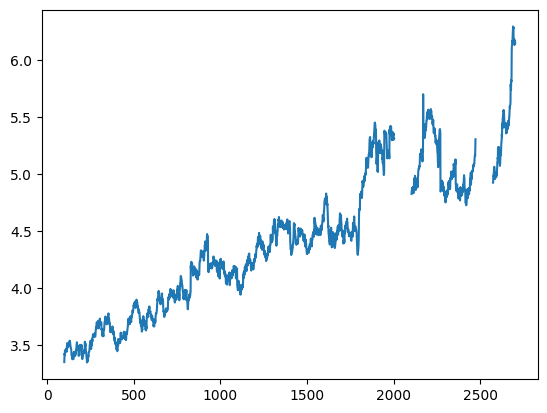

In [23]:
athlete_df['r1_mean_faults'].rolling(100).mean().plot()

LinregressResult(slope=73.7898819061215, intercept=1020.6988733234869, rvalue=0.24487909263423452, pvalue=3.679166575387345e-38, stderr=5.624656036937715, intercept_stderr=29.00654052528807)

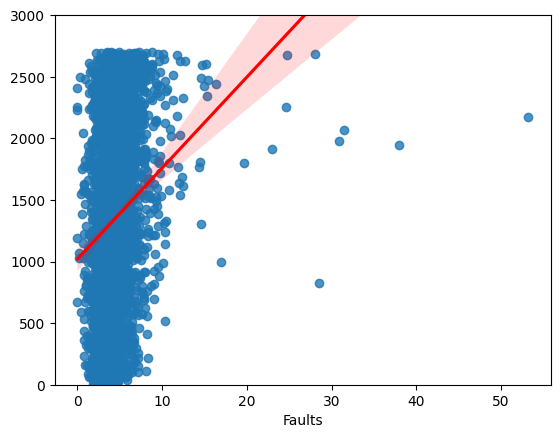

In [24]:
d = athlete_df.dropna(subset='r1_mean_faults')
sns.regplot(x=d['r1_mean_faults'], y=d.index, line_kws={'color': 'red'}).set(title="", xlabel='Faults')
plt.ylim(0, 3000)
linregress(d['r1_mean_faults'], d.index)

### First Round Time

<Axes: >

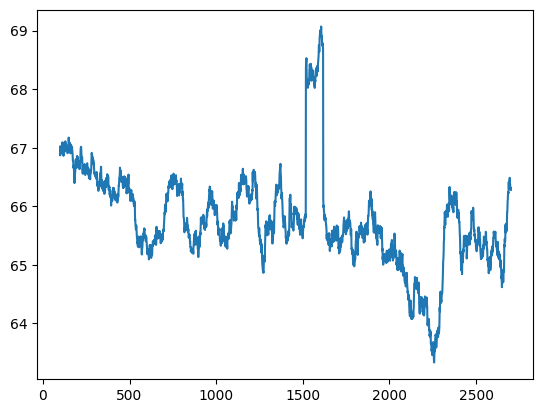

In [25]:
athlete_df['r1_mean_time'].rolling(100).mean().plot()

LinregressResult(slope=-5.553899271393156, intercept=1716.045377966954, rvalue=-0.05121501901305129, pvalue=0.007751383910387092, stderr=2.084243509526987, intercept_stderr=137.9970207783192)

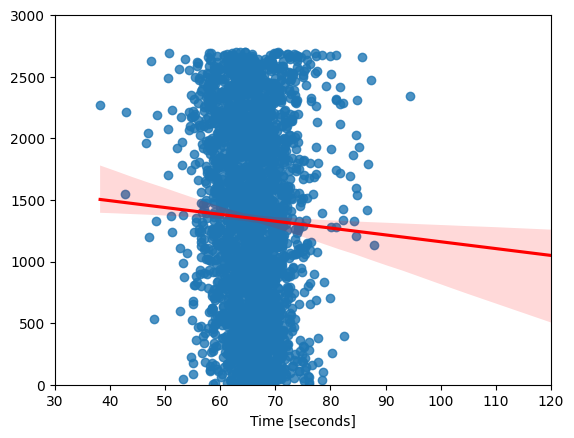

In [26]:
d = athlete_df.dropna(subset='r1_mean_time')
sns.regplot(x=d['r1_mean_time'], y=d.index, line_kws={'color': 'red'}).set(title="", xlabel='Time [seconds]')
plt.xlim(30, 120)
plt.ylim(0, 3000)
linregress(d['r1_mean_time'], d.index)

### Jump-off Faults

<Axes: >

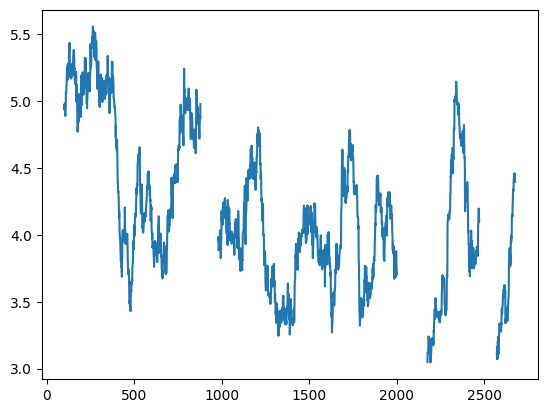

In [27]:
athlete_df['jo_mean_faults'].rolling(100).mean().plot()

### Jump-off Time

<Axes: >

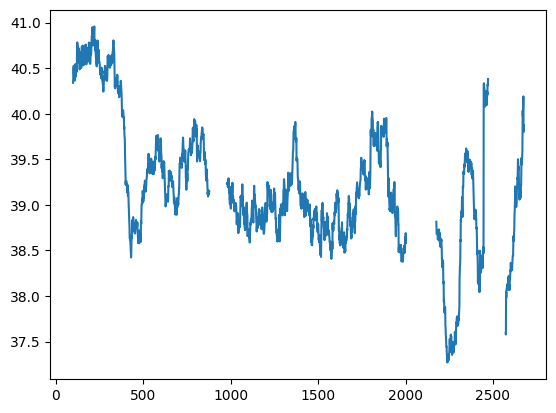

In [28]:
athlete_df['jo_mean_time'].rolling(100).mean().plot()

LinregressResult(slope=-5.3704957827193205, intercept=1560.1148931916161, rvalue=-0.04079085472637228, pvalue=0.03415164072729154, stderr=2.5340231531595814, intercept_stderr=100.6177061197746)

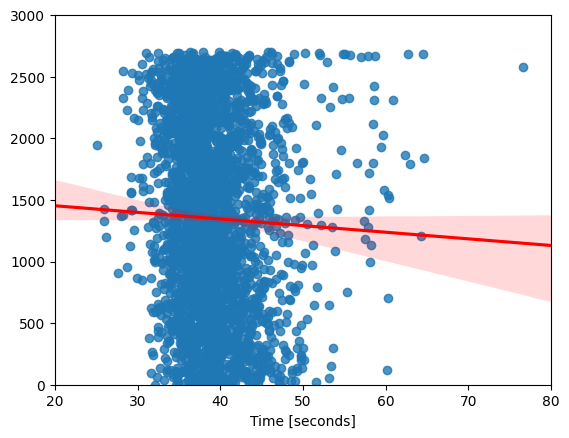

In [29]:
d = athlete_df.dropna(subset='jo_mean_time')
sns.regplot(x=d['jo_mean_time'], y=d.index, line_kws={'color': 'red'}).set(title="", xlabel='Time [seconds]')
plt.xlim(20, 80)
plt.ylim(0, 3000)
linregress(d['jo_mean_time'], d.index)

## Horse Details

<Axes: title={'center': 'Horses by Breed'}>

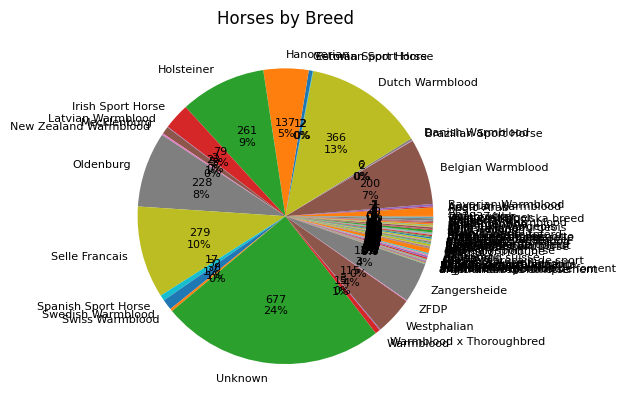

In [30]:
horse_df.groupby('Breed').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8}, title='Horses by Breed')

<Axes: title={'center': 'Horse Sex'}>

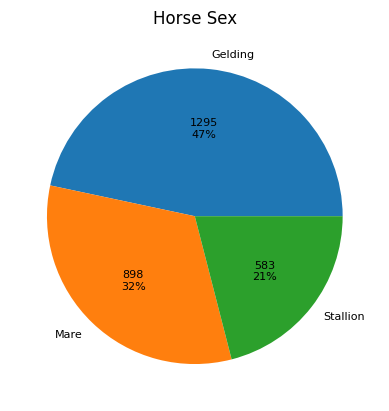

In [31]:
horse_df.groupby('Sex').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8}, title='Horse Sex')

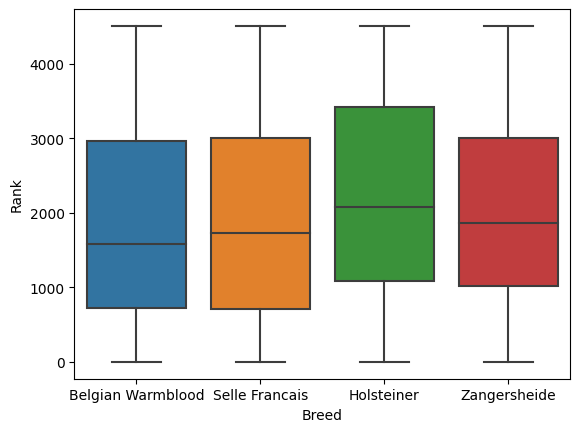

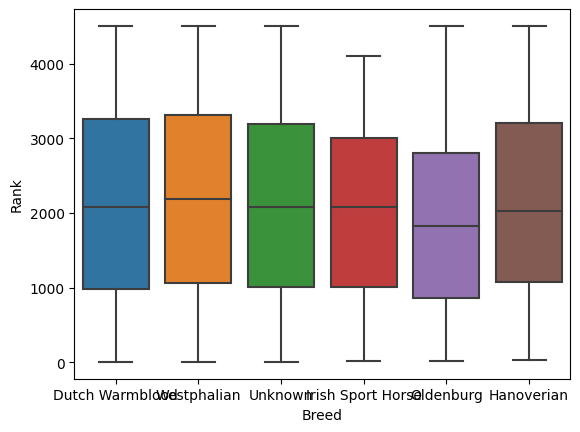

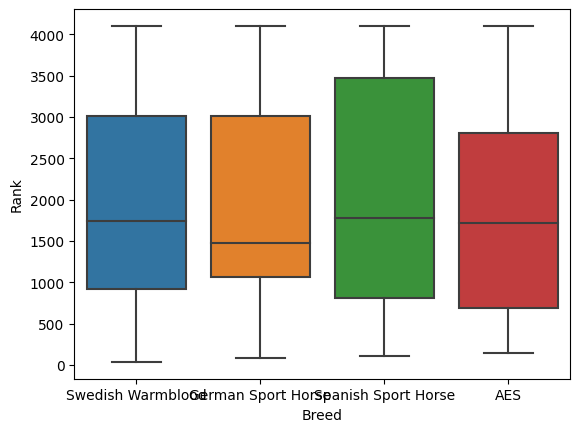

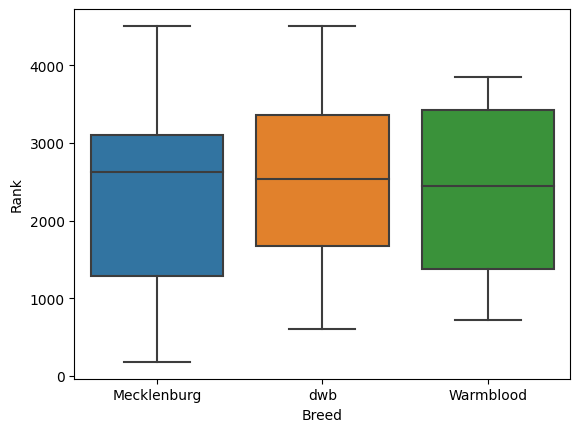

['Belgian Warmblood' 'Selle Francais' 'Holsteiner' 'Zangersheide'
 'Dutch Warmblood' 'Westphalian' 'Unknown' 'Brazilian Sport Horse'
 'Irish Sport Horse' 'Oldenburg' 'Hanoverian' 'Swiss Warmblood'
 'Swedish Warmblood' 'German Sport Horse' 'Spanish Sport Horse' 'be/sies'
 'Latvian Warmblood' 'New Zealand Warmblood' 'netherlands' 'AES'
 'Mecklenburg' 'ZFDP' 'rheinlaender' 'rheinländer' '0019374-bh'
 'Danish Warmblood' 'mexico' 'Austrian Warmblood' 'zweibrücker'
 'origine etrangere selle' 'demi-sang suisse'
 'asociacion argentina de foment' 'australian warmblood'
 'selle luxembourgeois' 'sella italiano' 'germany' 'rhein'
 'Bavarian Warmblood' 'seit' 'dwb' 'bh' 'cdls' 'Warmblood'
 'slovenian warmblood' 'shl' 'cde' 'switzerland' 'nrps' 'czweb'
 'caballo deportivo la silla' 'origine constatee' 'Estonian Sport Horse'
 'czewb' 'Anglo-Arab' 'canadian warmblood' 'silla argentina'
 'estonian sporthorse' 'hungarian sport horse' nan 'bavarian sport horse'
 'anglo-arabe de complement' 'württemberger

<Axes: xlabel='Breed', ylabel='Rank'>

In [32]:
from math import ceil
all_breeds = horse_df['Breed'].unique()
breeds_per_graph = 4
num_graphs = ceil(len(all_breeds)/breeds_per_graph)
idx = 0
dfs = []
for _ in range(num_graphs):
    breeds = all_breeds[idx:idx+breeds_per_graph]
    idx += breeds_per_graph
    if len(dfs) >= breeds_per_graph:
        df = pd.concat(dfs)
        var = 'Breed'
        fig = sns.boxplot(x=var, y="Rank", data=df)
        plt.show()
        dfs = []
    for b in breeds:
        df = horse_df[horse_df['Breed']==b]
        if len(df) > 10:
            dfs.append(df)
else:
    if len(dfs) > 0:
        df = pd.concat(dfs)
        var = 'Breed'
        fig = sns.boxplot(x=var, y="Rank", data=df)
        plt.show()
print(all_breeds)
var = 'Breed'
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.boxplot(x=var, y="Rank", data=horse_df[:5])
# fig.axis(ymin=0, ymax=800000);
fig

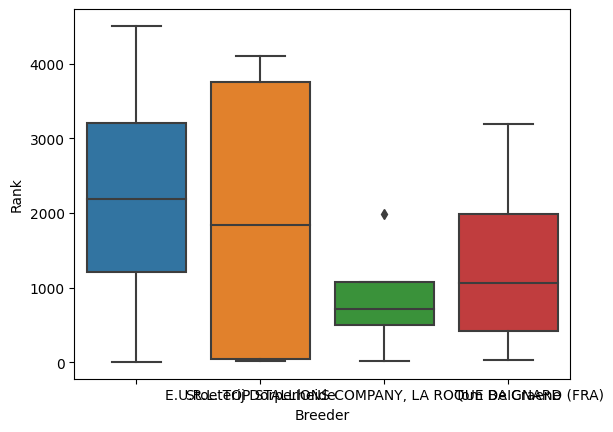

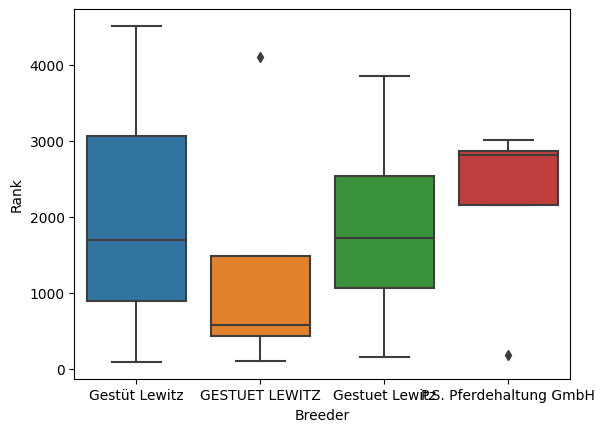

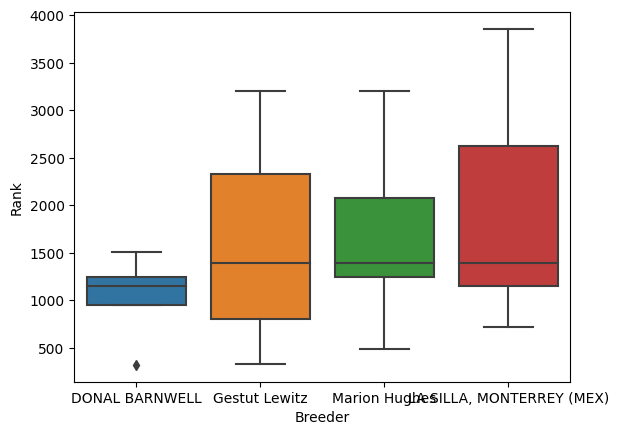

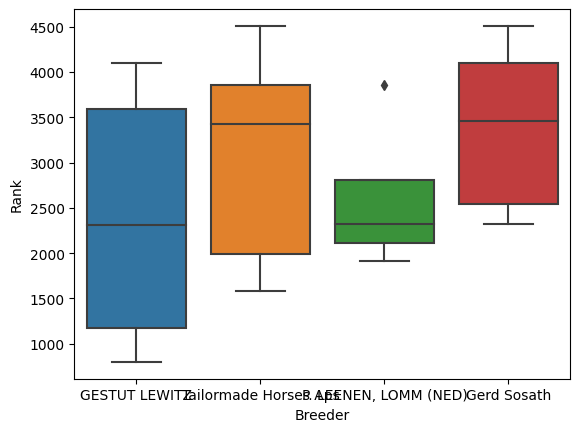

<Axes: xlabel='Breeder', ylabel='Rank'>

In [33]:
all_breeders = horse_df['Breeder'].unique()
breeders_per_graph = 4
num_graphs = ceil(len(all_breeders)/breeders_per_graph)
idx = 0
dfs = []
for _ in range(num_graphs):
    breeders = all_breeders[idx:idx+breeders_per_graph]
    idx += breeders_per_graph
    if len(dfs) >= breeders_per_graph:
        df = pd.concat(dfs)
        var = 'Breeder'
        fig = sns.boxplot(x=var, y="Rank", data=df)
        plt.show()
        dfs = []
    for b in breeders:
        df = horse_df[horse_df['Breeder']==b]
        if len(df) > 3:
            dfs.append(df)
else:
    if len(dfs) > 0:
        df = pd.concat(dfs)
        var = 'Breeder'
        fig = sns.boxplot(x=var, y="Rank", data=df)
        plt.show()

fig



## Horse Performance

<Axes: >

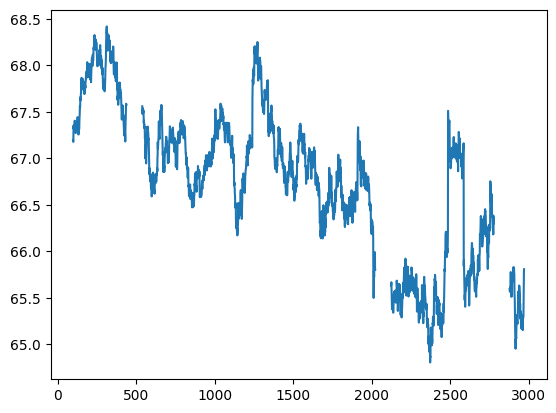

In [34]:
horse_df['r1_mean_time'].rolling(100).mean().plot()

LinregressResult(slope=-4.087736006047837, intercept=2030.3234458730271, rvalue=-0.3303597270091432, pvalue=7.375303840996538e-80, stderr=0.20979265580988724, intercept_stderr=28.791430572441485)

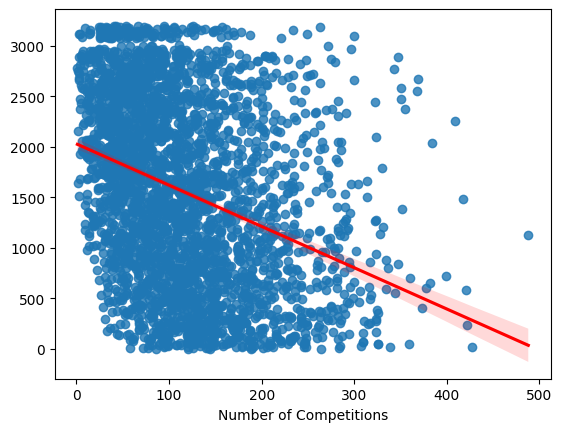

In [35]:
d = horse_df.dropna(subset='num_competitions')
sns.regplot(x=d['num_competitions'], y=d.index, line_kws={'color': 'red'}).set(title="", xlabel='Number of Competitions')

linregress(d['num_competitions'], d.index)

LinregressResult(slope=-20.199846169450353, intercept=2900.9371681912426, rvalue=-0.12426589001470918, pvalue=3.839481351010526e-12, stderr=2.8978511301301815, intercept_stderr=193.79650081377952)

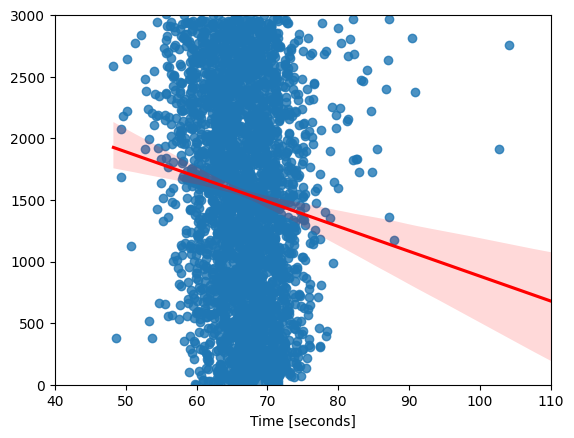

In [36]:
d = horse_df.dropna(subset='r1_mean_time')
sns.regplot(x=d['r1_mean_time'], y=d.index, line_kws={'color': 'red'}).set(title="", xlabel='Time [seconds]')
plt.xlim(40, 110)
plt.ylim(0, 3000)
linregress(d['r1_mean_time'], d.index)

### Jump-off Faults

<Axes: >

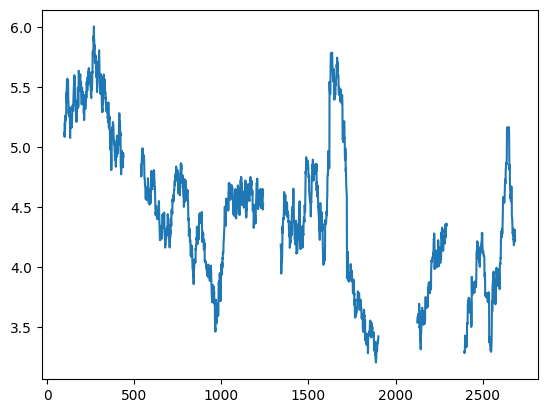

In [37]:
horse_df['jo_mean_faults'].rolling(100).mean().plot()

(0.0, 30.0)

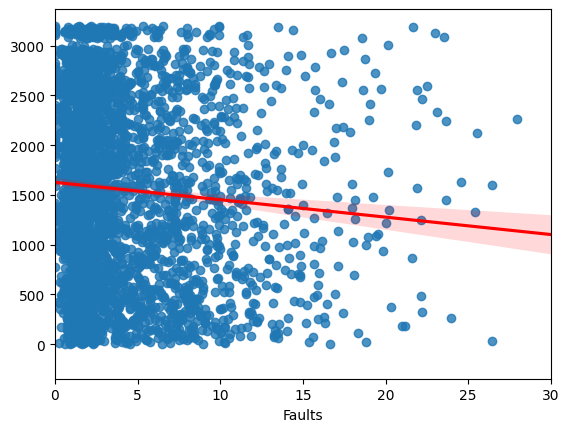

In [38]:
d = horse_df.dropna(subset='jo_mean_faults')
sns.regplot(x=d['jo_mean_faults'], y=d.index, line_kws={'color': 'red'}).set(title="", xlabel='Faults')
linregress(d['jo_mean_faults'], d.index)
plt.xlim(0, 30)

### Jump-off Time

<Axes: >

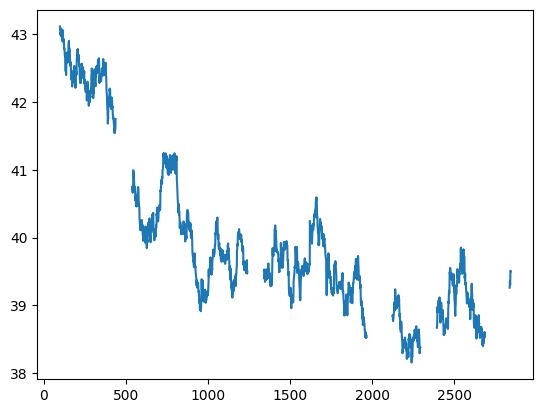

In [39]:
horse_df['jo_mean_time'].rolling(100).mean().plot()

LinregressResult(slope=-36.376660935073915, intercept=2999.1793514292585, rvalue=-0.20452981969341757, pvalue=1.5444080385412633e-30, stderr=3.1329126094940336, intercept_stderr=125.68720746604146)

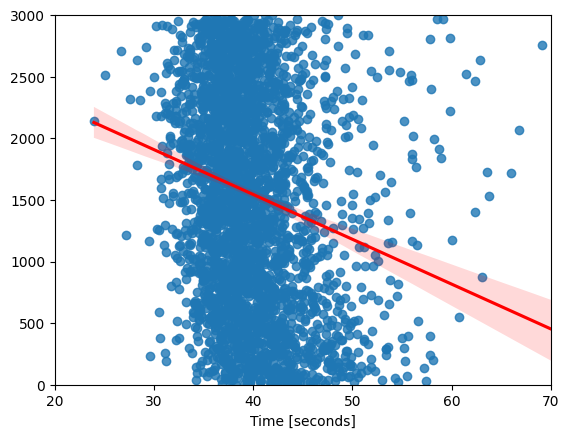

In [40]:
d = horse_df.dropna(subset='jo_mean_time')
sns.regplot(x=d['jo_mean_time'], y=d.index, line_kws={'color': 'red'}).set(title="", xlabel='Time [seconds]')
plt.xlim(20, 70)
plt.ylim(0, 3000)
linregress(d['jo_mean_time'], d.index)

## Horse Pedigree

<Axes: >

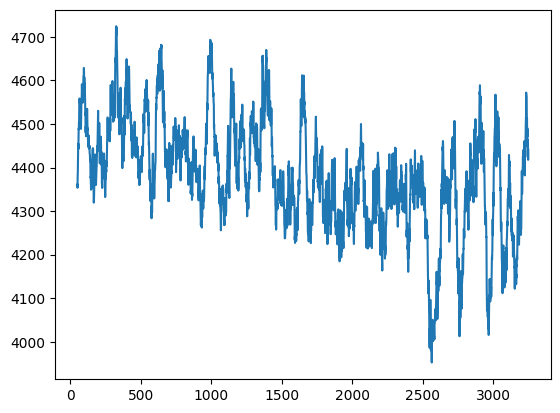

In [41]:
horse_df['Age'].rolling(50).mean().plot()


LinregressResult(slope=-0.10012764284279625, intercept=2062.4869923776373, rvalue=-0.08499823974435423, pvalue=1.22335272945876e-06, stderr=0.0205981585983503, intercept_stderr=91.68380749480163)

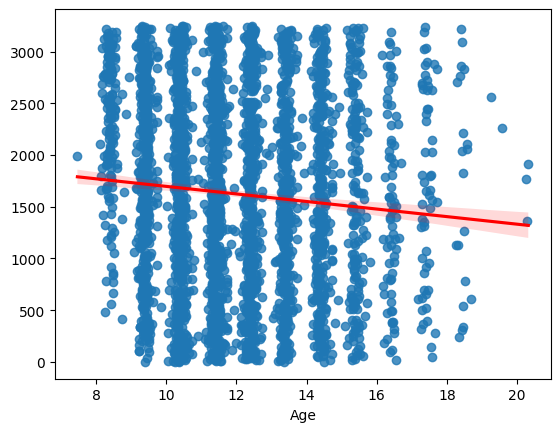

In [42]:
sns.regplot(x=horse_df['Age']/365, y=horse_df.index, line_kws={'color': 'red'}).set(title="", xlabel='Age')
linregress(horse_df['Age'], horse_df.index)

# Machine Learning Models

In [43]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import category_encoders as ce


def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))
    
    
def find_cum_feature_importance(features, encoded_features, feature_importances):
# calculate the cumulative feature importance across the encoding
    cum_feature_importances = {f: 0 for f in features}
    for f, imp in zip(encoded_features, feature_importances):

        for base_name in features:
          
            if base_name in [f[:-2], f[:-3], f[:-4], f]:
              
                cum_feature_importances[base_name] += imp
    return cum_feature_importances


def encode(X, y):
#     encoder = ce.BinaryEncoder()
    encoder = ce.OneHotEncoder()
#     encoder = ce.hashing.HashingEncoder()
#     encoder = ce.gray.GrayEncoder()
    encoder.fit(X, y)
    return encoder.transform(X).fillna(0), y


from catboost import Pool, CatBoostRegressor


def run_model(X, y, cat_features=[]):
    features = X.columns
#     X, y = encode(X, y)
    y = np.array(y)
    encoded_features = X.columns
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    scores = []
    regrs = []
    fold = 1
    for train_index, test_index in kfold.split(X): 
        print('Kfold', fold)

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]

        y_train, y_test = y[train_index], y[test_index]
        print(X_train.shape)

    
        # specify the training parameters 
        model = CatBoostRegressor(loss_function='RMSE', verbose=False)
        #train the model
        if cat_features == []:
            model.fit(X_train, y_train)
        else:
            
            model.fit(X_train, y_train, cat_features=cat_features)
#         xgb_model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(mean_squared_error(y_test, y_pred))
        regrs.append(linregress(y_test, y_pred))
        sns.regplot(x=y_pred, y=y_test, line_kws={'color': 'red'}).set(title=f"Rank vs Predicted Rank {fold}", xlabel='Predicted Rank', ylabel='Rank')
        plt.show()
        fold += 1
        
    display_scores(np.sqrt(scores))
    print(regrs)
    print(model.feature_importances_)
    print(find_cum_feature_importance(features, encoded_features, model.feature_importances_))
    return model
    

## Horse Details

Kfold 1
(2599, 15)


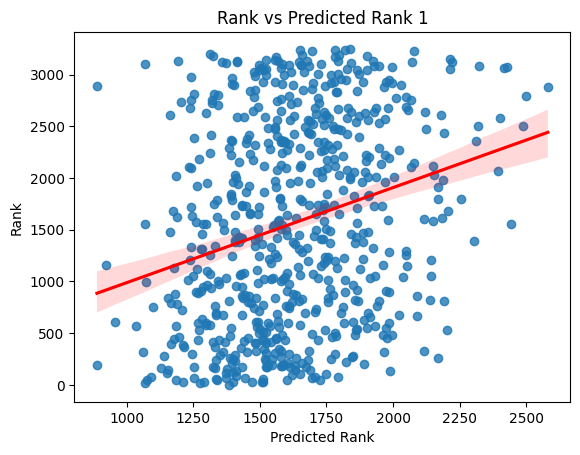

Kfold 2
(2599, 15)


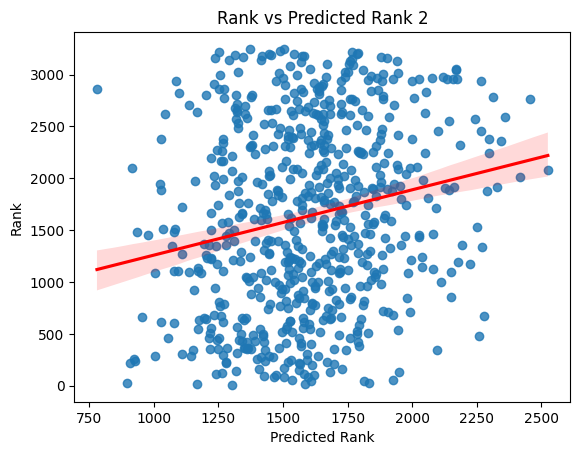

Kfold 3
(2599, 15)


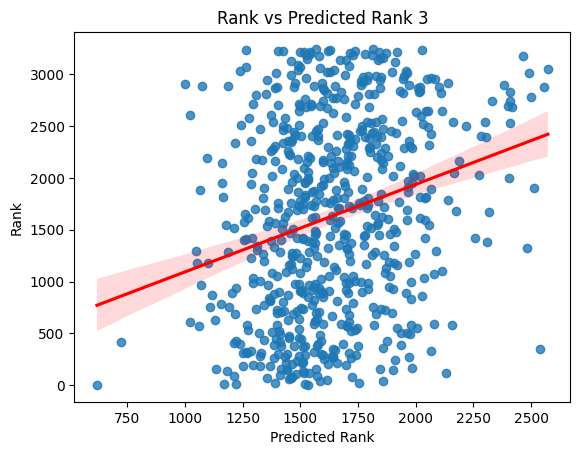

Kfold 4
(2599, 15)


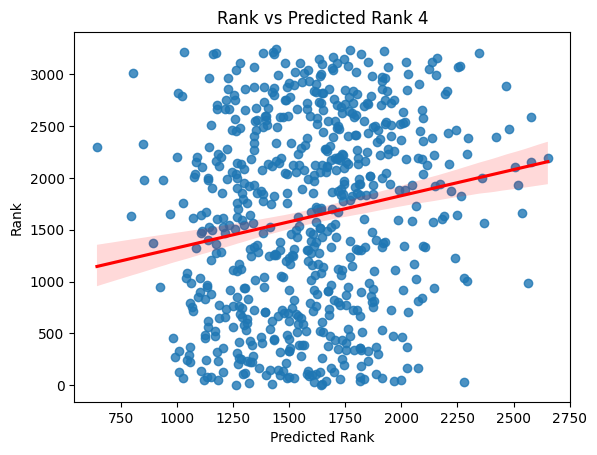

Kfold 5
(2600, 15)


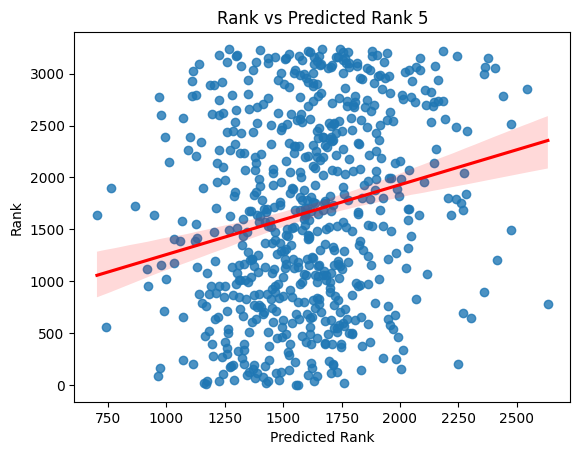

Scores: [947.57636746 885.07432341 906.55924542 931.94033697 924.8490425 ]
Mean: 919.200
Std: 21.558
[LinregressResult(slope=0.07459334941338891, intercept=1509.8070734165099, rvalue=0.2618062261294142, pvalue=1.197242050386813e-11, stderr=0.010802248330426138, intercept_stderr=19.937453807401692), LinregressResult(slope=0.06496021237939407, intercept=1489.5221519649033, rvalue=0.20230108420732254, pvalue=1.97542741992997e-07, stderr=0.01235343809079806, intercept_stderr=23.02059829018848), LinregressResult(slope=0.07868262915493106, intercept=1514.8213852348977, rvalue=0.2578903097822286, pvalue=2.463502599804053e-11, stderr=0.011580085701926422, intercept_stderr=21.841005294099514), LinregressResult(slope=0.06511442668231947, intercept=1485.438654534086, rvalue=0.18102502886399557, pvalue=3.4041406005885367e-06, stderr=0.013896836826509915, intercept_stderr=25.993674389190218), LinregressResult(slope=0.07040974619476081, intercept=1485.7953860083612, rvalue=0.21769588267466836, pvalu

In [44]:

features = ['Gender', 'Castrated/Sterilized', 'Breed',  'Administering NF', 'Issuing NF', 'num_ownerships', 'Age', 'Color', 'Sire Age', 'Sire Color', 'Dam Age', 'Dam Color', 'Breeder', 'Sire', 'Dam']  
X = horse_df[features].fillna('')
y = horse_df.index
cat_features = ['Gender', 'Castrated/Sterilized', 'Breed',  'Administering NF', 'Issuing NF', 'Color', 'Sire Color', 'Dam Color', 'Breeder', 'Sire', 'Dam']
model = run_model(X, y, cat_features=cat_features)

In [45]:
# LinregressResult(slope=0.07290854378475546, intercept=1508.7695765136039, rvalue=0.245060256671288, pvalue=2.4103488673495895e-10, stderr=0.011331029411303263, intercept_stderr=20.913412520044965), LinregressResult(slope=0.06733065230416199, intercept=1495.5916839437934, rvalue=0.2085438236122231, pvalue=8.062864134005408e-08, stderr=0.0124043103899598, intercept_stderr=23.115398681342185), LinregressResult(slope=0.07877442854735439, intercept=1524.341269721901, rvalue=0.2600267362819039, pvalue=1.6642999611908063e-11, stderr=0.01149152451358545, intercept_stderr=21.67397152308993), LinregressResult(slope=0.06542308158753585, intercept=1481.3401184567804, rvalue=0.18879844088759712, pvalue=1.2481711481511582e-06, stderr=0.01336791242885846, intercept_stderr=25.00433496319774), LinregressResult(slope=0.07227332928970204, intercept=1478.0059912681909, rvalue=0.2265316223464407, pvalue=5.349828913464376e-09, stderr=0.012216807806677565, intercept_stderr=23.341111002863755)]

In [46]:
shap.initjs()
explainer = shap.TreeExplainer(model)
# X, y = encode(X, y)
shap_values = explainer.shap_values(X)

In [47]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], X.iloc[:100,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


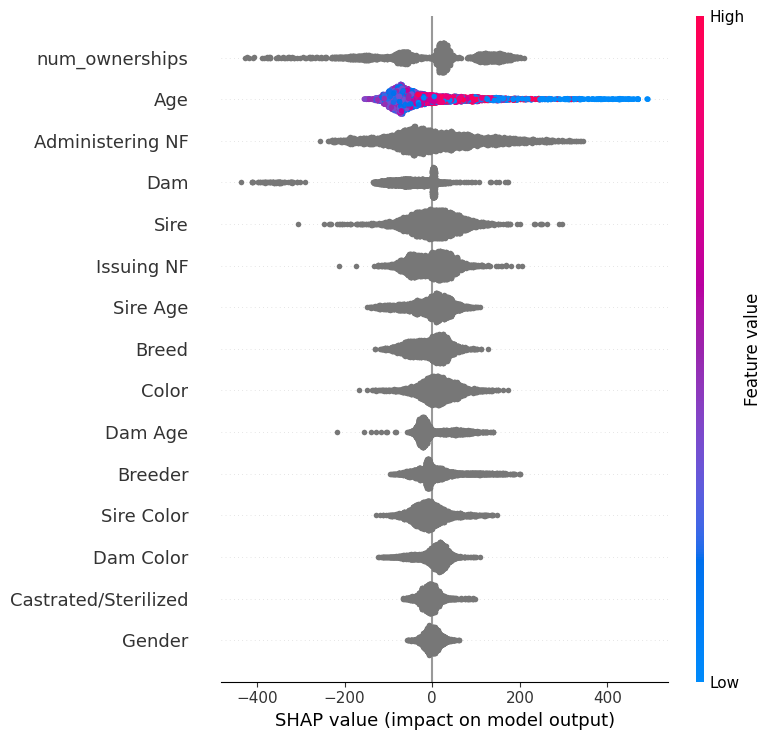

In [48]:
shap.summary_plot(shap_values, X)

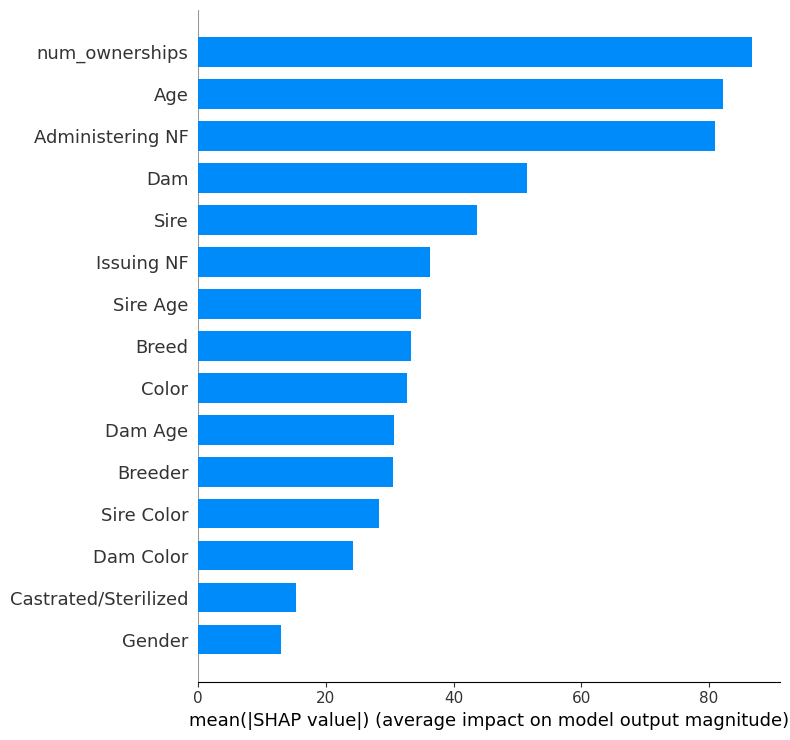

In [49]:
shap.summary_plot(shap_values, X, plot_type='bar')

In [50]:
horse_df.groupby('Color')['Rank'].mean()

Color
Bay         2105.235422
Black       1733.283582
Chestnut    1927.996337
Grey        2088.563492
Other       2093.239057
Name: Rank, dtype: float64

In [51]:
horse_df.groupby('Color')['Rank'].std()

Color
Bay         1284.814986
Black       1144.171379
Chestnut    1271.947541
Grey        1263.411098
Other       1270.704457
Name: Rank, dtype: float64

In [52]:
horse_df.groupby('Color')['Rank'].median()

Color
Bay         1990.0
Black       1394.0
Chestnut    1828.5
Grey        2076.0
Other       2076.0
Name: Rank, dtype: float64

## Horse Performance

Kfold 1
(2599, 10)


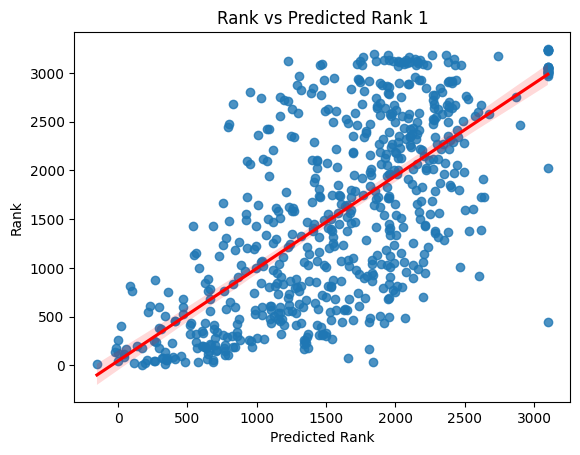

Kfold 2
(2599, 10)


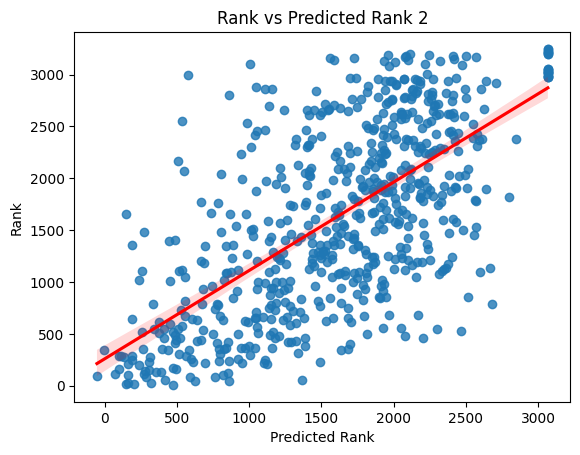

Kfold 3
(2599, 10)


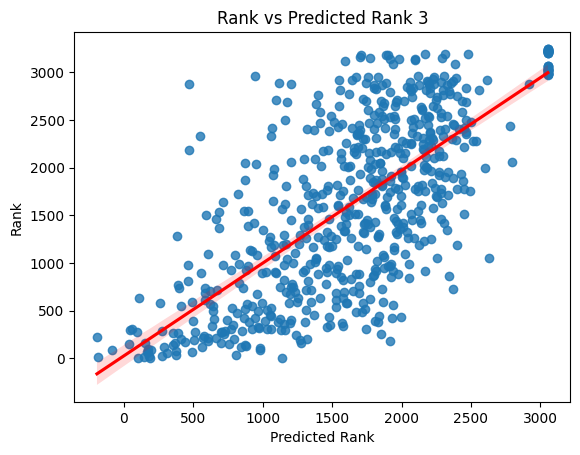

Kfold 4
(2599, 10)


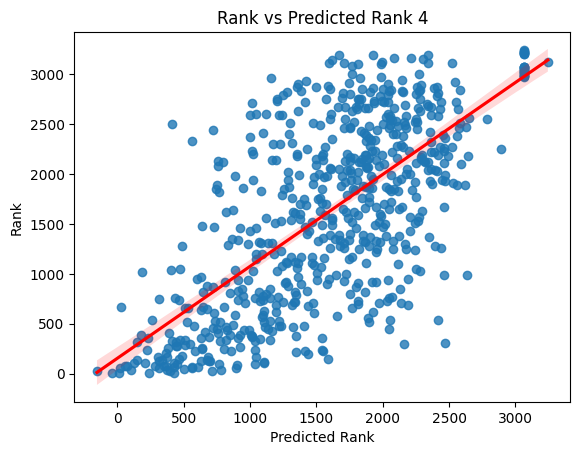

Kfold 5
(2600, 10)


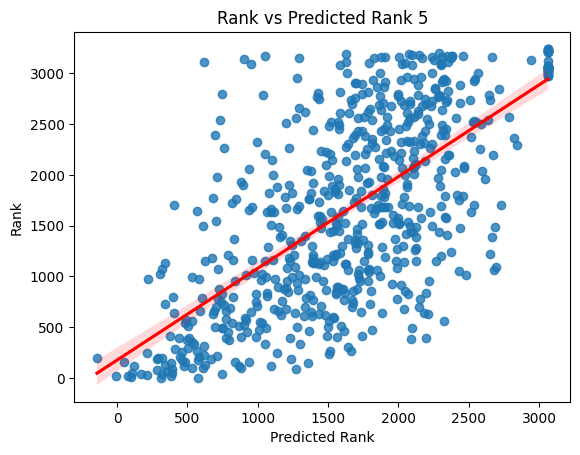

Scores: [713.25119115 680.9744533  657.41009102 680.39579293 702.8842609 ]
Mean: 686.983
Std: 19.478
[LinregressResult(slope=0.49754535572549574, intercept=821.8676001042546, rvalue=0.6872845097977135, pvalue=4.96048970370714e-92, stderr=0.020657486371945914, intercept_stderr=38.127033161943075), LinregressResult(slope=0.5122589526748241, intercept=778.3496762381357, rvalue=0.6606280503318716, pvalue=9.603351478719719e-83, stderr=0.022867527015918016, intercept_stderr=42.61357441177519), LinregressResult(slope=0.5229308284878125, intercept=799.9896565746293, rvalue=0.7132432984164113, pvalue=4.304003820479783e-102, stderr=0.02018763072546217, intercept_stderr=38.07555150276614), LinregressResult(slope=0.512076863675647, intercept=762.8793510021636, rvalue=0.6865158776497874, pvalue=9.491322135620575e-92, stderr=0.021305908472282427, intercept_stderr=39.85215155854183), LinregressResult(slope=0.4946775496894942, intercept=824.396994395542, rvalue=0.6681607938347254, pvalue=3.84314467754

In [53]:

features = ['r1_mean_time', 'r1_mean_faults', 'jo_mean_time', 'jo_mean_faults',
       'el_pct', 'break_time', 'std_break_time', 'num_competitions', 'mean_height', 'pct_160'] 
X = horse_df[features]
y = horse_df.index

model = run_model(X, y)


In [54]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


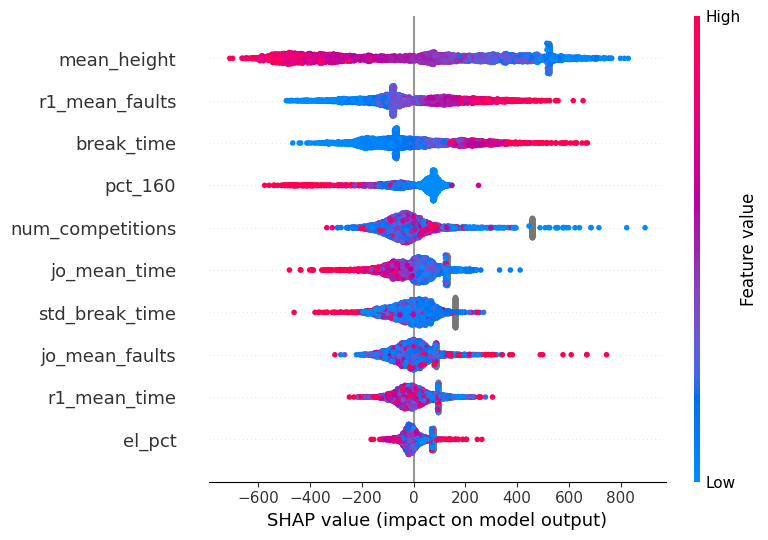

In [55]:
shap.summary_plot(shap_values, X)

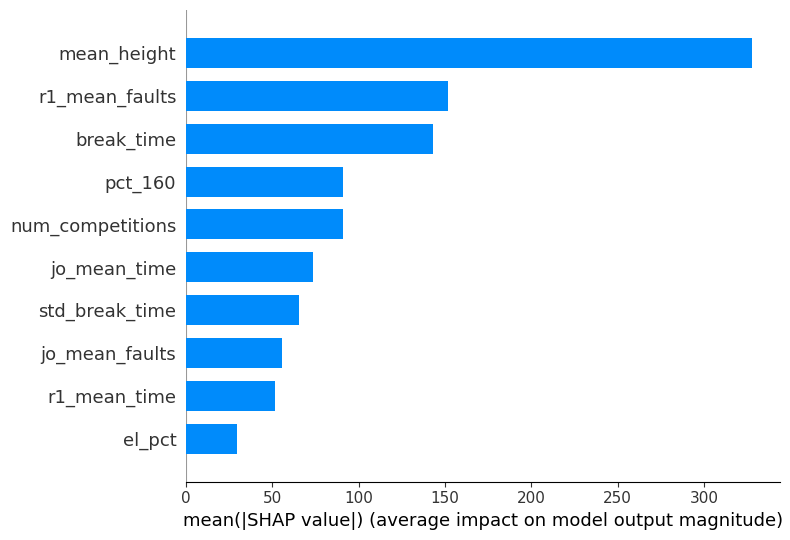

In [56]:
shap.summary_plot(shap_values, X, plot_type='bar')

## All Horse Features

Kfold 1
(2599, 25)


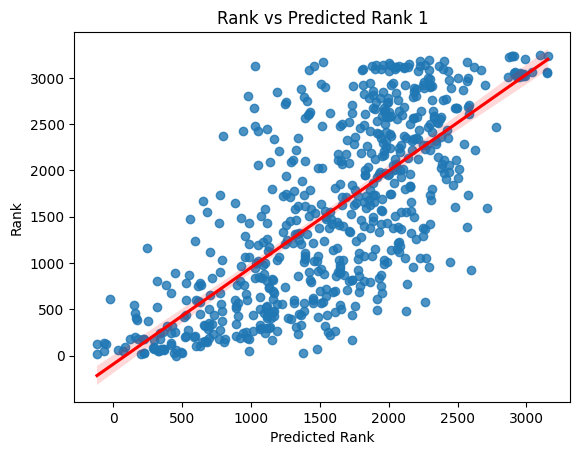

Kfold 2
(2599, 25)


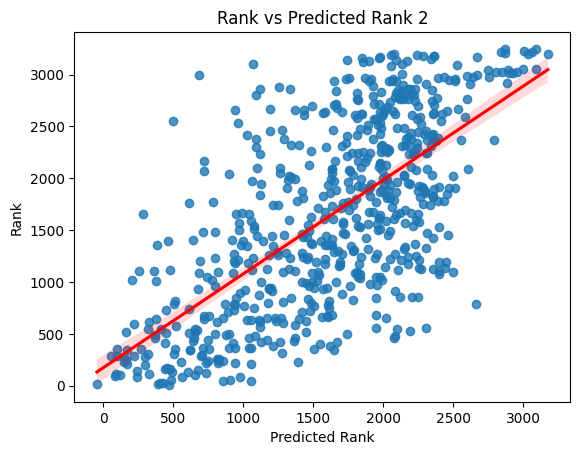

Kfold 3
(2599, 25)


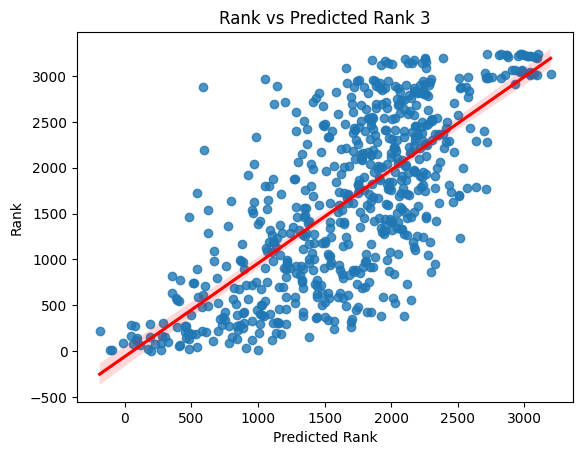

Kfold 4
(2599, 25)


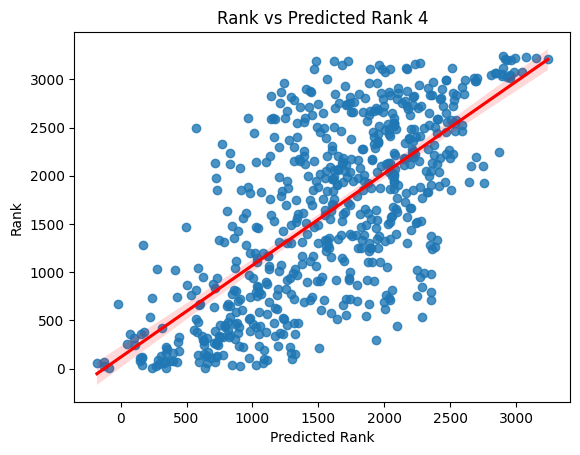

Kfold 5
(2600, 25)


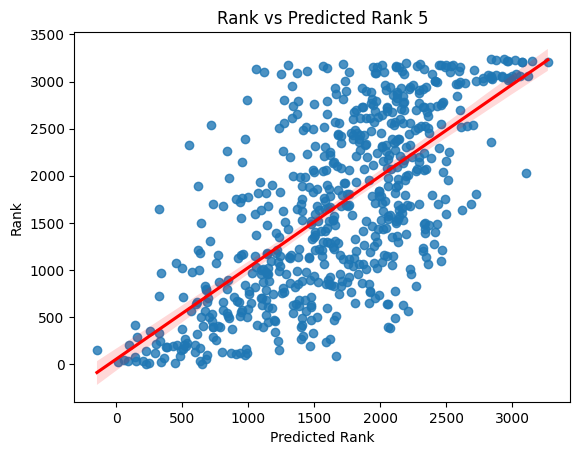

Scores: [668.25615269 666.76312135 648.0200993  672.92579165 686.39139002]
Mean: 668.471
Std: 12.347
[LinregressResult(slope=0.5133308182768727, intercept=785.4890010482445, rvalue=0.7321534805214737, pvalue=3.697064409450057e-110, stderr=0.018760477721393002, intercept_stderr=34.62576924116187), LinregressResult(slope=0.4998261965310089, intercept=797.6049347196827, rvalue=0.6724331853341485, pvalue=9.76563456543631e-87, stderr=0.021612584793835384, intercept_stderr=40.274992993418444), LinregressResult(slope=0.5143476341500502, intercept=826.0416961665719, rvalue=0.7232632635736627, pvalue=2.777523379980784e-106, stderr=0.019292213493525143, intercept_stderr=36.3867200893759), LinregressResult(slope=0.505726025507947, intercept=757.2508065045757, rvalue=0.6942121845265958, pvalue=1.304614092842773e-94, stderr=0.020598213601238768, intercept_stderr=38.5284265789323), LinregressResult(slope=0.48135746750318986, intercept=855.879233549727, rvalue=0.683618624981147, pvalue=1.475094458562

In [57]:
features = ['Gender', 'Castrated/Sterilized', 'Breed',  'Administering NF', 'Issuing NF', 'num_ownerships', 'Age', 'Color', 'Sire Age', 'Sire Color', 'Dam Age', 'Dam Color', 'Breeder', 'Sire', 'Dam', 'r1_mean_time', 'r1_mean_faults', 'jo_mean_time', 'jo_mean_faults', 'el_pct', 'break_time', 'std_break_time', 'num_competitions', 'mean_height', 'pct_160']

X = horse_df[features].fillna(method='ffill')
y = horse_df.index

cat_features = ['Gender', 'Castrated/Sterilized', 'Breed',  'Administering NF', 'Issuing NF', 'Color', 'Sire Color', 'Dam Color', 'Breeder', 'Sire', 'Dam']
model = run_model(X, y, cat_features=cat_features)


In [58]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


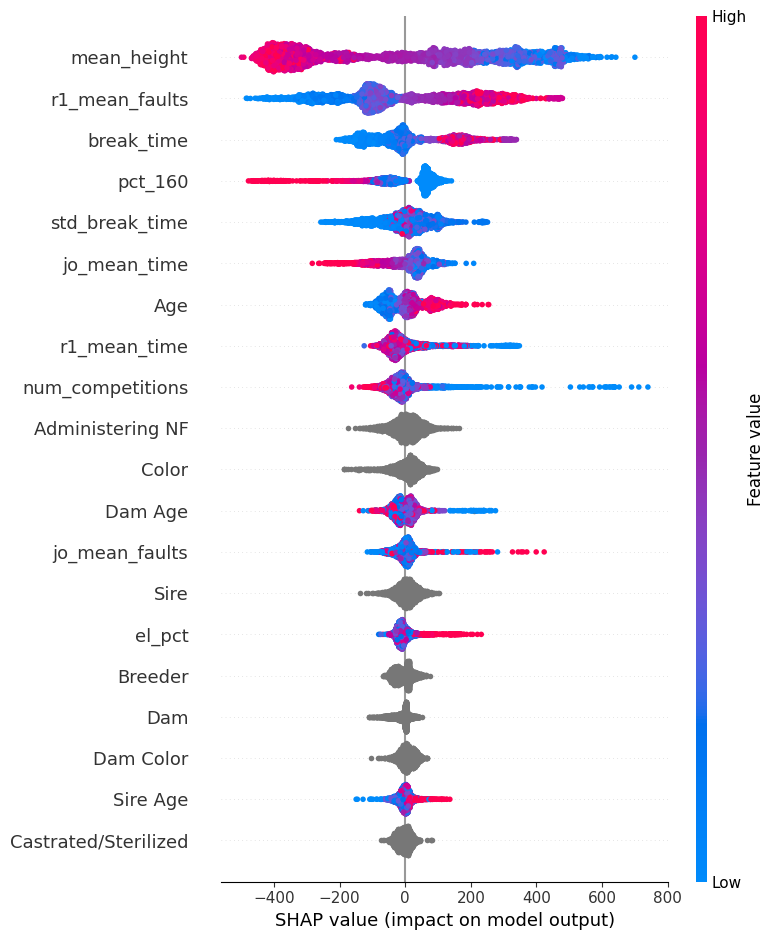

In [59]:
shap.summary_plot(shap_values, X)

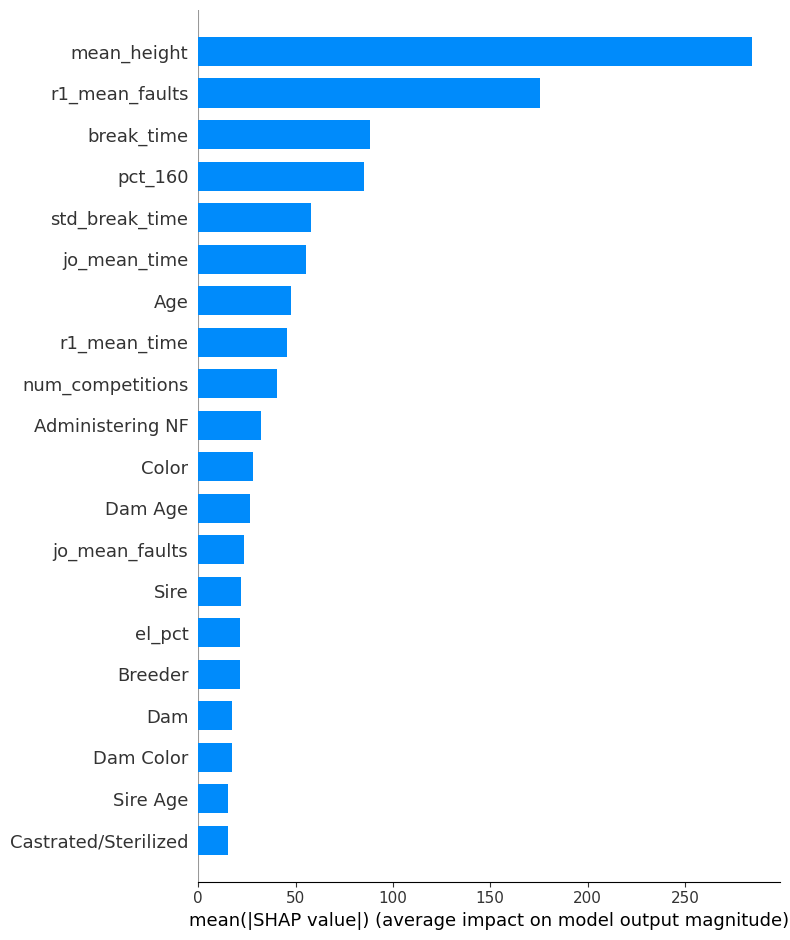

In [60]:
shap.summary_plot(shap_values, X, plot_type='bar')

## Athlete Details

Kfold 1
(2161, 4)


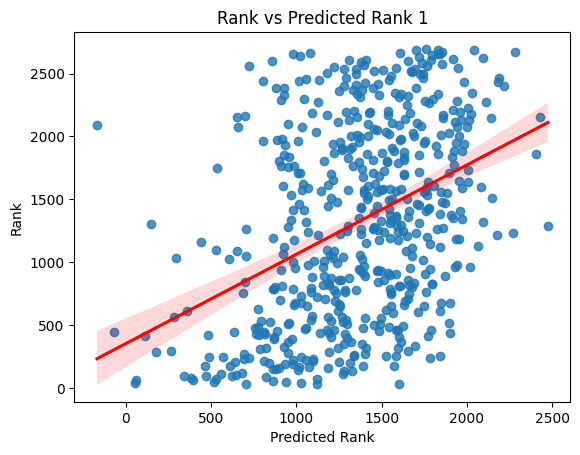

Kfold 2
(2161, 4)


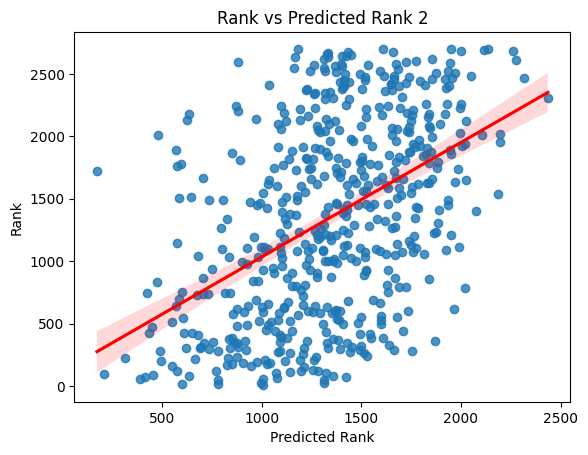

Kfold 3
(2162, 4)


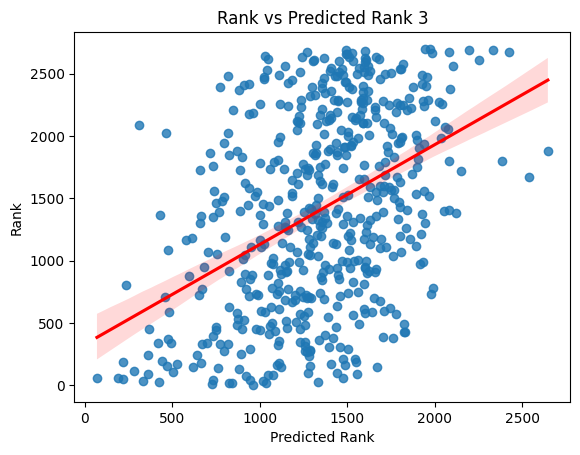

Kfold 4
(2162, 4)


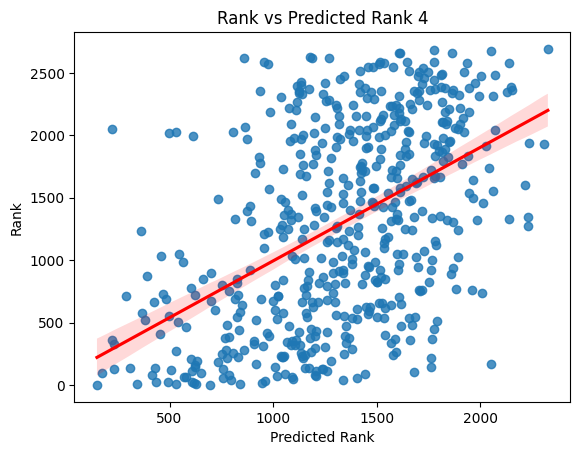

Kfold 5
(2162, 4)


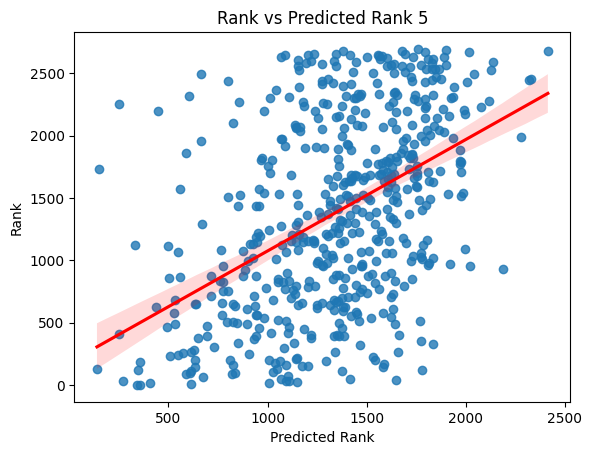

Scores: [720.79200781 688.57984511 713.18162677 692.4524227  683.51810803]
Mean: 699.705
Std: 14.592
[LinregressResult(slope=0.22492796489301284, intercept=1063.440817396378, rvalue=0.399565940452126, pvalue=3.731157948321913e-22, stderr=0.02222746588141888, intercept_stderr=33.99739823467951), LinregressResult(slope=0.24017037555851964, intercept=1019.3246514080922, rvalue=0.4694661493797888, pvalue=5.263006302183555e-31, stderr=0.019456159329242977, intercept_stderr=30.31616959004027), LinregressResult(slope=0.22790856728496894, intercept=1020.7761695919063, rvalue=0.4272100736054946, pvalue=2.291793205696313e-25, stderr=0.020795514290802047, intercept_stderr=33.36088655086284), LinregressResult(slope=0.2642268788501635, intercept=991.0567798753668, rvalue=0.4902734828545506, pvalue=5.316969249861585e-34, stderr=0.020251120274497908, intercept_stderr=30.78833540547288), LinregressResult(slope=0.24486452495048702, intercept=1007.2918967791961, rvalue=0.4676804232626644, pvalue=1.06618

In [61]:
athlete_df.columns

features = ['Gender', 'Competing for', 'Number of horses', 'Age']

X = athlete_df[features]
y = athlete_df.index

model = run_model(X, y, cat_features=['Gender', 'Competing for'])

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


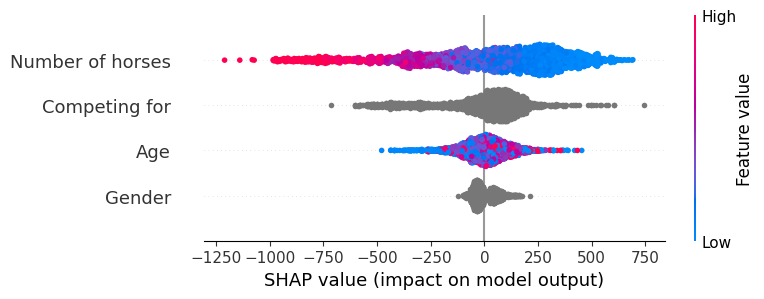

In [63]:
shap.summary_plot(shap_values, X)

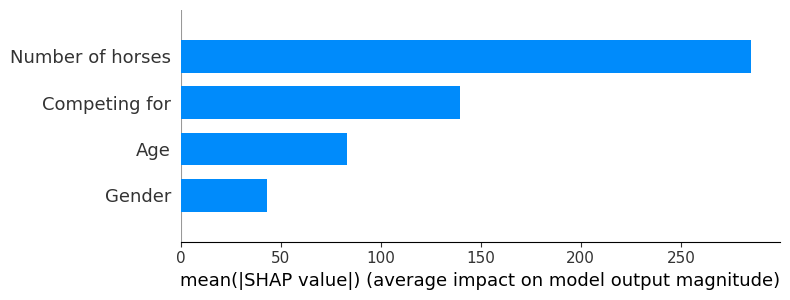

In [64]:
shap.summary_plot(shap_values, X, plot_type='bar')

## Athlete Performance

Kfold 1
(2161, 7)


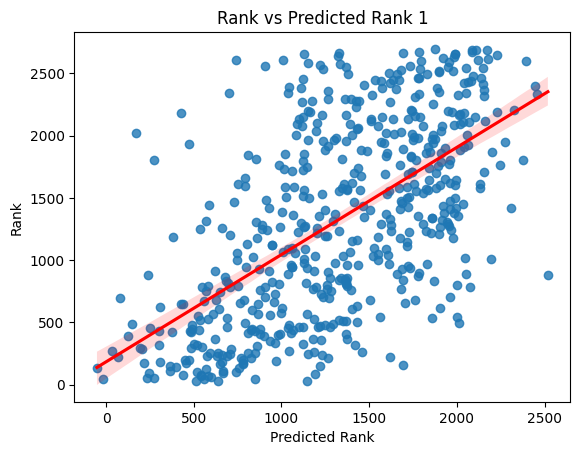

Kfold 2
(2161, 7)


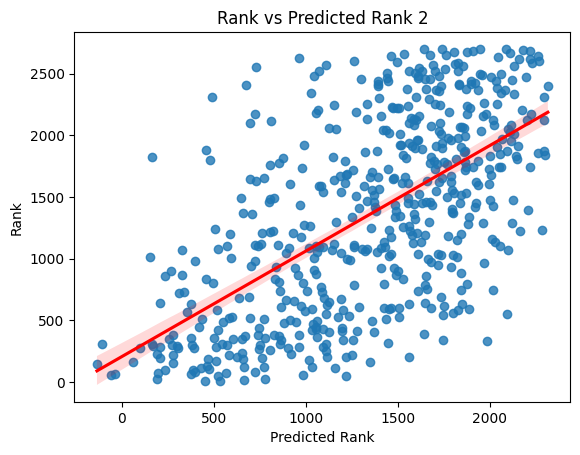

Kfold 3
(2162, 7)


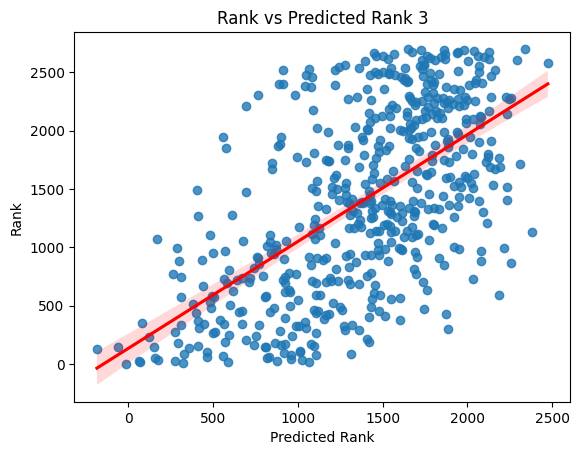

Kfold 4
(2162, 7)


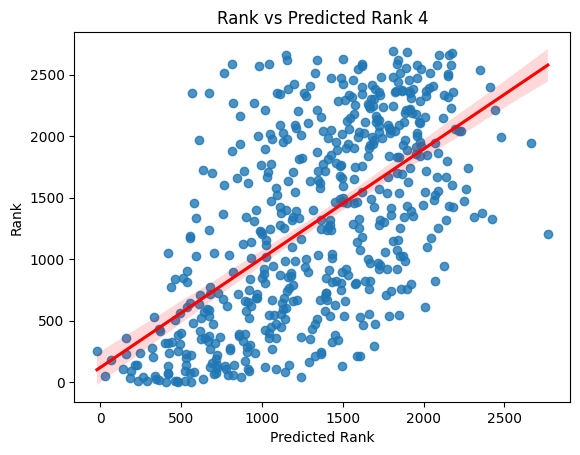

Kfold 5
(2162, 7)


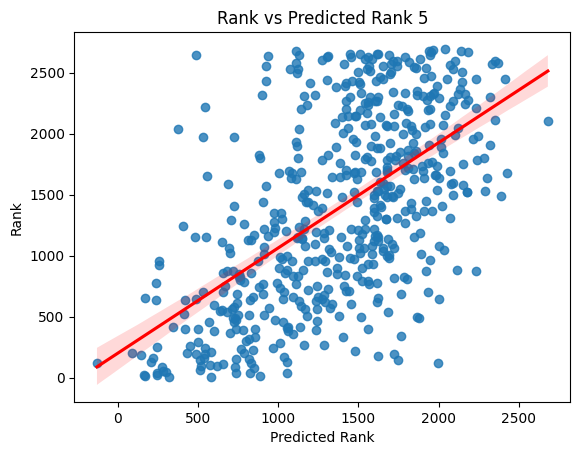

Scores: [621.23291466 621.26019214 619.6387135  632.66646824 628.47051516]
Mean: 624.654
Std: 5.043
[LinregressResult(slope=0.42169496376959265, intercept=763.9742329731884, rvalue=0.6027405945160473, pvalue=8.232925446819995e-55, stderr=0.02404597007240617, intercept_stderr=36.778840415369615), LinregressResult(slope=0.43848170426240923, intercept=744.6021090631622, rvalue=0.612326379497072, pvalue=5.595773904629064e-57, stderr=0.02438561594788215, intercept_stderr=37.997143018994315), LinregressResult(slope=0.40833941128489337, intercept=811.3035347256723, rvalue=0.6111330232218898, pvalue=1.3295513052121913e-56, stderr=0.022801354152240595, intercept_stderr=36.57872454808166), LinregressResult(slope=0.4157841859144062, intercept=786.9590879191247, rvalue=0.6077182376392397, pvalue=7.9368685163234445e-56, stderr=0.023424945420868912, intercept_stderr=35.6135891099728), LinregressResult(slope=0.39789114291238664, intercept=822.5132040787862, rvalue=0.5861738032548465, pvalue=3.8476188

In [65]:
features = ['r1_mean_time', 'r1_mean_faults', 'jo_mean_time',
       'jo_mean_faults', 'el_pct', 'break_time', 'std_break_time']
X = athlete_df[features]
y = athlete_df.index

model = run_model(X, y)

In [66]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


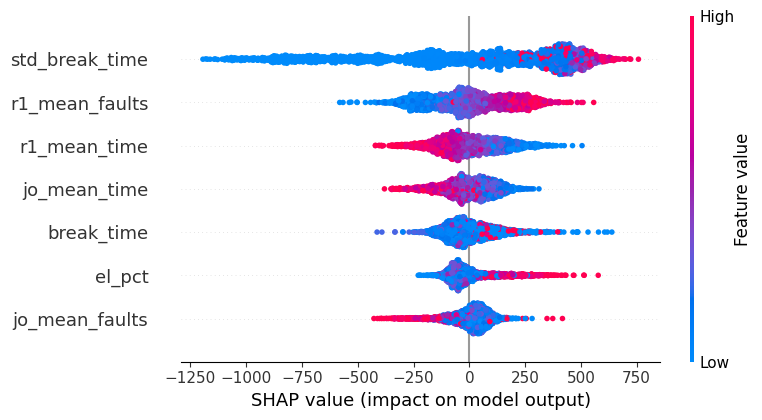

In [67]:
shap.summary_plot(shap_values, X)

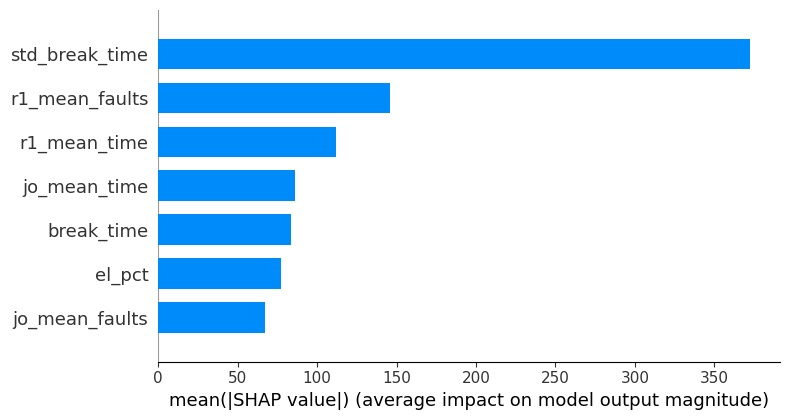

In [68]:
shap.summary_plot(shap_values, X, plot_type='bar')

## All Athlete Features

Kfold 1
(2161, 12)


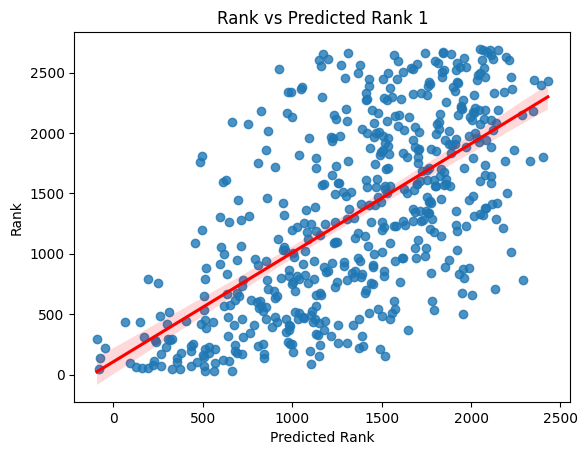

Kfold 2
(2161, 12)


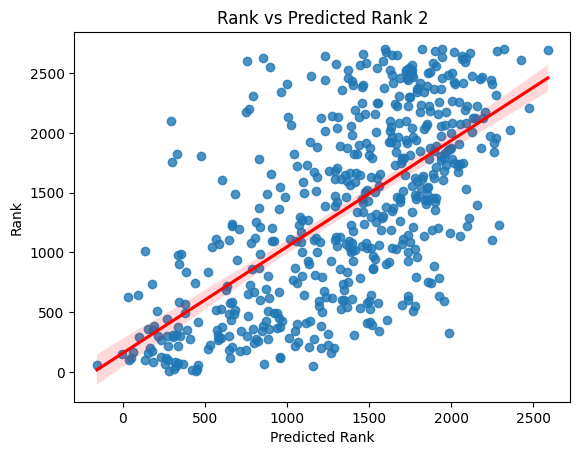

Kfold 3
(2162, 12)


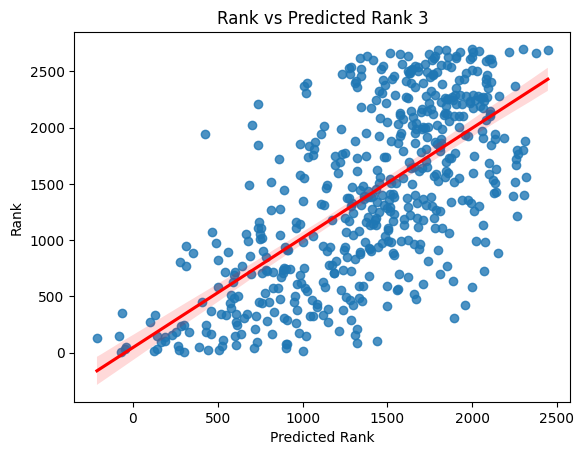

Kfold 4
(2162, 12)


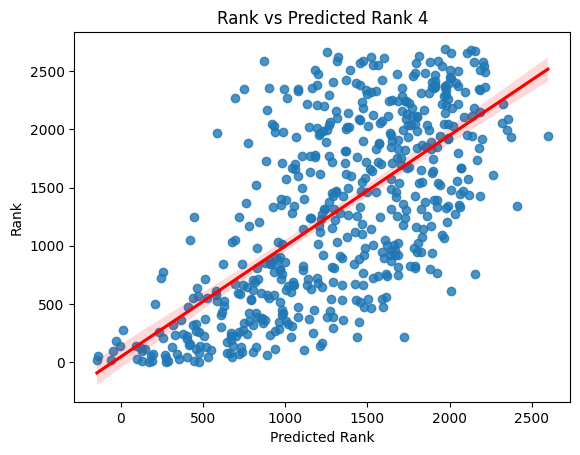

Kfold 5
(2162, 12)


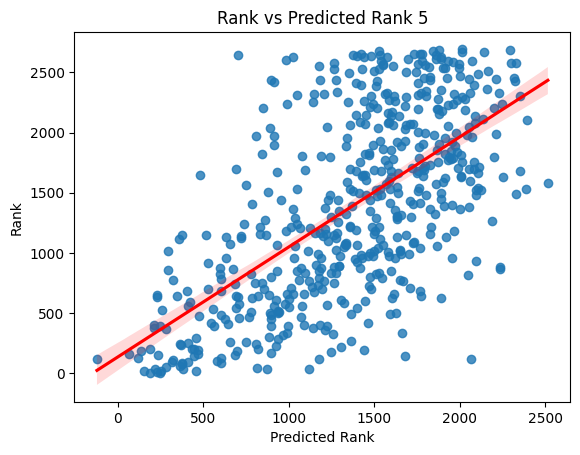

Scores: [594.62724631 595.25651814 579.13530634 588.51319314 596.18655939]
Mean: 590.744
Std: 6.400
[LinregressResult(slope=0.45863089350535574, intercept=739.1760870740427, rvalue=0.6433589980920853, pvalue=1.5580577883807293e-64, stderr=0.023507010575313583, intercept_stderr=35.954490003461586), LinregressResult(slope=0.47604948457360924, intercept=698.6220107446865, rvalue=0.6502615244127679, pvalue=2.460875518523256e-66, stderr=0.023956190192581325, intercept_stderr=37.328021030233465), LinregressResult(slope=0.461660728498232, intercept=743.9110688461651, rvalue=0.6707466267382993, pvalue=7.71601275965205e-72, stderr=0.0220086655347291, intercept_stderr=35.30706592645969), LinregressResult(slope=0.4725045162728996, intercept=701.9900949394955, rvalue=0.6706079737992421, pvalue=8.452257305314353e-72, stderr=0.022534085036183975, intercept_stderr=34.259189553239715), LinregressResult(slope=0.4442017939058638, intercept=751.0557855396545, rvalue=0.6368917593127967, pvalue=8.957628760

In [69]:
features = ['Gender', 'Competing for', 'Number of horses', 'num_competitions', 'Age', 'r1_mean_time', 'r1_mean_faults', 'jo_mean_time',
       'jo_mean_faults', 'el_pct', 'break_time', 'std_break_time']

X = athlete_df[features]
y = athlete_df.index

model = run_model(X, y, cat_features=['Gender', 'Competing for'])

In [70]:
horse_df.rename(columns={'index': 'Horse ID'}).columns

Index(['Horse ID', '_id', 'Birth Name', 'Current Name', 'Status',
       'Last Change', 'Date of Birth', 'Gender', 'Castrated/Sterilized',
       'Breed', 'Sire', 'Sire's UELN', 'Dam', 'Dam's UELN', 'Sire of Dam',
       'Dam's Sire's UELN', 'Administering NF', 'National ID', 'Issuing NF',
       'Issuing Date', 'Valid Until', 'Pony', 'ownerships', 'Breeder',
       'num_ownerships', 'CurrentName', 'Sex', 'Age', 'Color',
       'ColorComplement', 'Sire HorseFEIID', 'Sire CurrentName', 'Sire Sex',
       'Sire Age', 'Sire Color', 'Sire ColorComplement',
       'Sire's Sire HorseFEIID', 'Sire's Sire CurrentName', 'Sire's Sire Sex',
       'Sire's Sire Age', 'Sire's Sire Color', 'Sire's Sire ColorComplement',
       'Sire's Dam HorseFEIID', 'Sire's Dam CurrentName', 'Sire's Dam Sex',
       'Sire's Dam Age', 'Sire's Dam Color', 'Sire's Dam ColorComplement',
       'Dam HorseFEIID', 'Dam CurrentName', 'Dam Sex', 'Dam Age', 'Dam Color',
       'Dam ColorComplement', 'Dam's Sire HorseFEIID',

In [71]:

explainer = shap.TreeExplainer(model)
# X, y = encode(X, y)
shap_values = explainer.shap_values(X)

In [72]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], X.iloc[:100,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


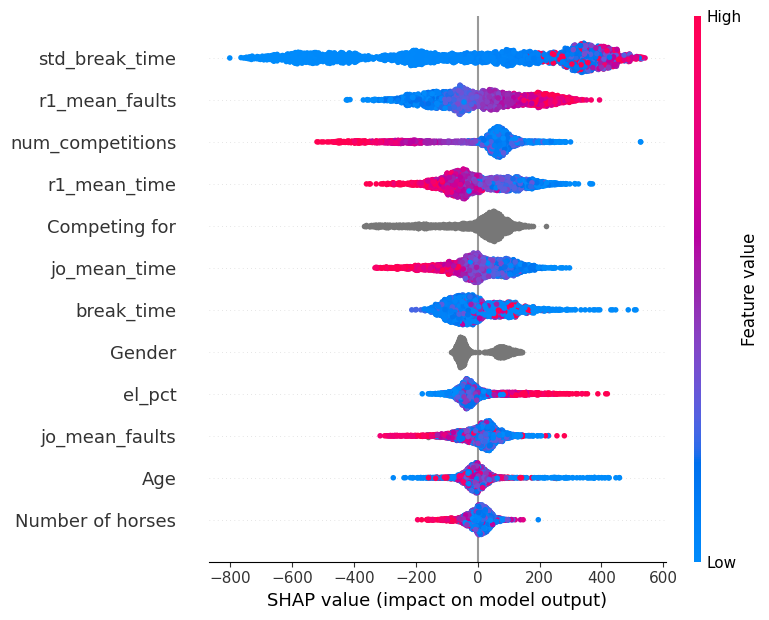

In [73]:
shap.summary_plot(shap_values, X)

## Horse and Athlete All Features

Kfold 1
(1382, 37)


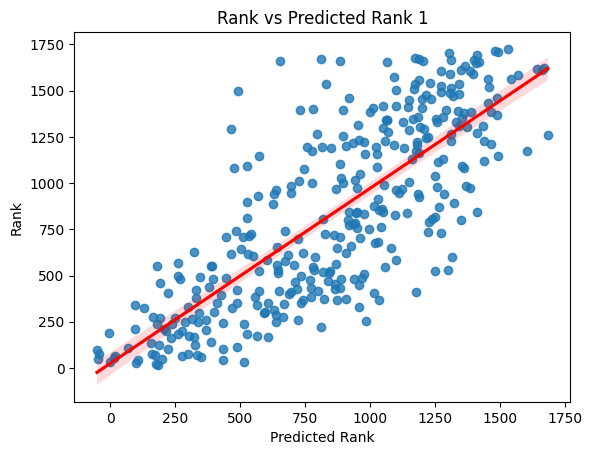

Kfold 2
(1382, 37)


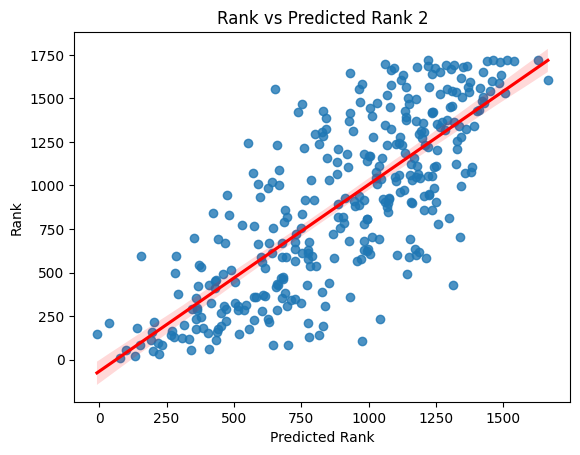

Kfold 3
(1382, 37)


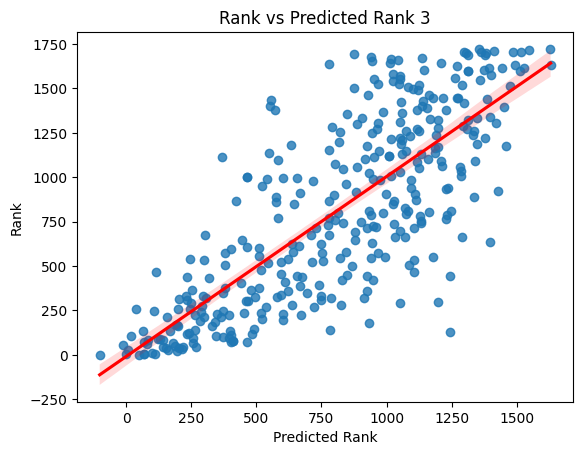

Kfold 4
(1383, 37)


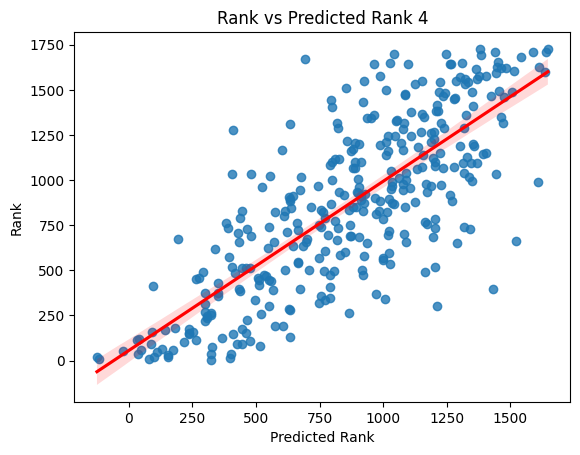

Kfold 5
(1383, 37)


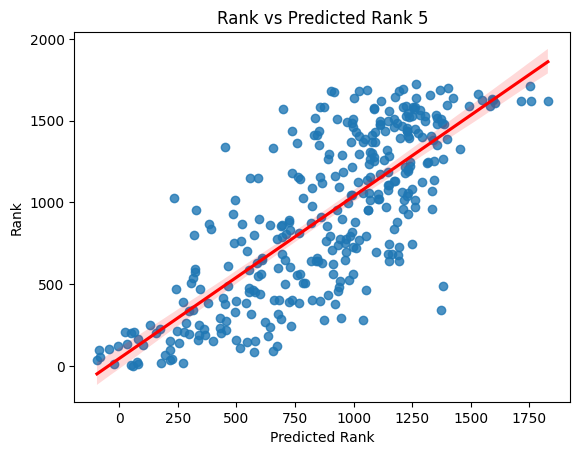

Scores: [308.31140039 307.99808904 323.62707523 297.75244412 319.1050143 ]
Mean: 311.359
Std: 9.124
[LinregressResult(slope=0.6462513992246568, intercept=316.88503601554635, rvalue=0.7827680029348403, pvalue=7.553112911741461e-73, stderr=0.027701196190812932, intercept_stderr=26.90572968804363), LinregressResult(slope=0.5696224291641091, intercept=387.0126118321936, rvalue=0.7815985489083473, pvalue=1.7014109953895936e-72, stderr=0.02451076131022544, intercept_stderr=25.008949909101855), LinregressResult(slope=0.612041271580342, intercept=312.7091479397185, rvalue=0.7874178870295382, pvalue=2.8435375376445363e-74, stderr=0.025832867774478876, intercept_stderr=24.92041223238438), LinregressResult(slope=0.6472504296209358, intercept=303.3255272714854, rvalue=0.7793221568548235, pvalue=1.3023666759503393e-71, stderr=0.028100556599891628, intercept_stderr=27.711838486603437), LinregressResult(slope=0.6072595187282812, intercept=319.27645741414835, rvalue=0.7759788204210989, pvalue=1.248692

In [74]:
df = horse_df.rename(columns={'index': 'Horse ID'}).merge(athlete_df.rename(columns={col: "Athlete " + col for col in athlete_df.columns}), left_on='Horse ID', right_on='Athlete Horse ID').fillna(method='ffill')

features = ['Athlete Gender',
 'Athlete Competing for',
 'Athlete Number of horses',
 'Athlete num_competitions',
 'Athlete r1_mean_time',
 'Athlete r1_mean_faults',
 'Athlete jo_mean_time',
 'Athlete jo_mean_faults',
 'Athlete el_pct',
 'Athlete break_time',
 'Athlete std_break_time',
    'Athlete Age',
 'Athlete pct_160',
'Athlete mean_height',
 'Gender', 'Castrated/Sterilized', 'Breed',  'Administering NF', 'Issuing NF', 'num_ownerships', 'Age', 'Color', 'Sire Age', 'Sire Color', 'Dam Age', 'Dam Color', 'Breeder', 'Sire', 'Dam', 'r1_mean_time', 'r1_mean_faults', 'jo_mean_time', 'jo_mean_faults', 'el_pct', 'break_time', 'std_break_time', 'num_competitions'
]
X = df[features]
# X['Breed'] = X['Breed'].apply(standardize_breed)
y = df.index  #['Rank']
cat_features = ['Gender', 'Castrated/Sterilized', 'Breed',  'Administering NF', 'Issuing NF', 'Color', 'Sire Color', 'Dam Color', 'Breeder', 'Sire', 'Dam', 'Athlete Gender', 'Athlete Competing for']
model = run_model(X, y, cat_features=cat_features)

In [75]:
explainer = shap.TreeExplainer(model)
# X, y = encode(X, y)
shap_values = explainer.shap_values(X)


In [76]:
shap.force_plot(explainer.expected_value, shap_values[:100,:], X.iloc[:100,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


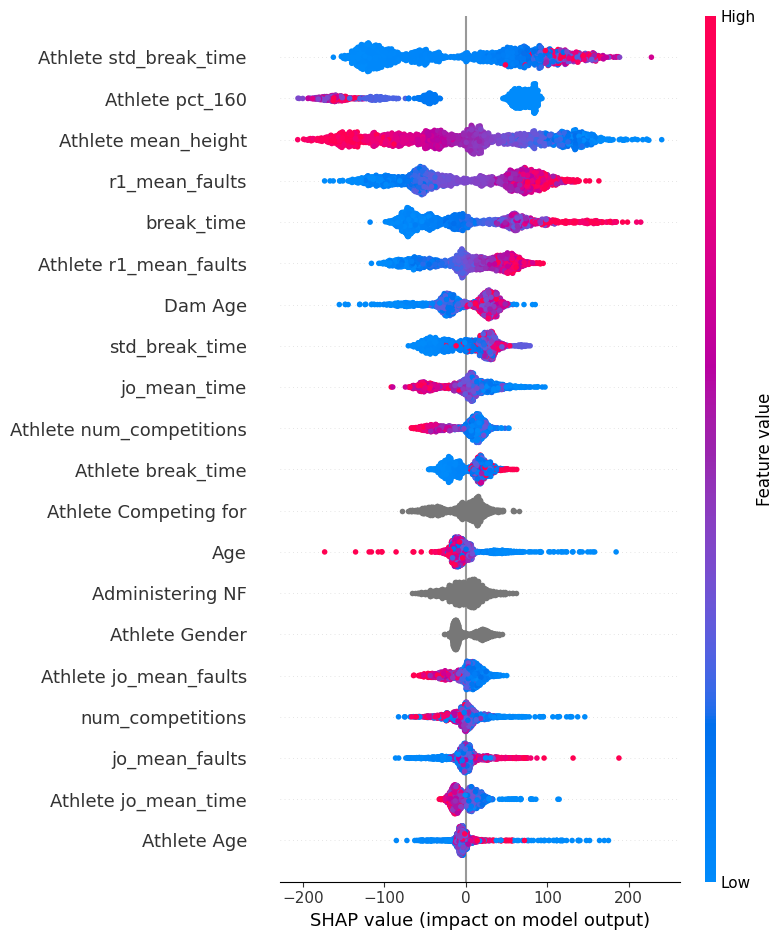

In [77]:
shap.summary_plot(shap_values, X)

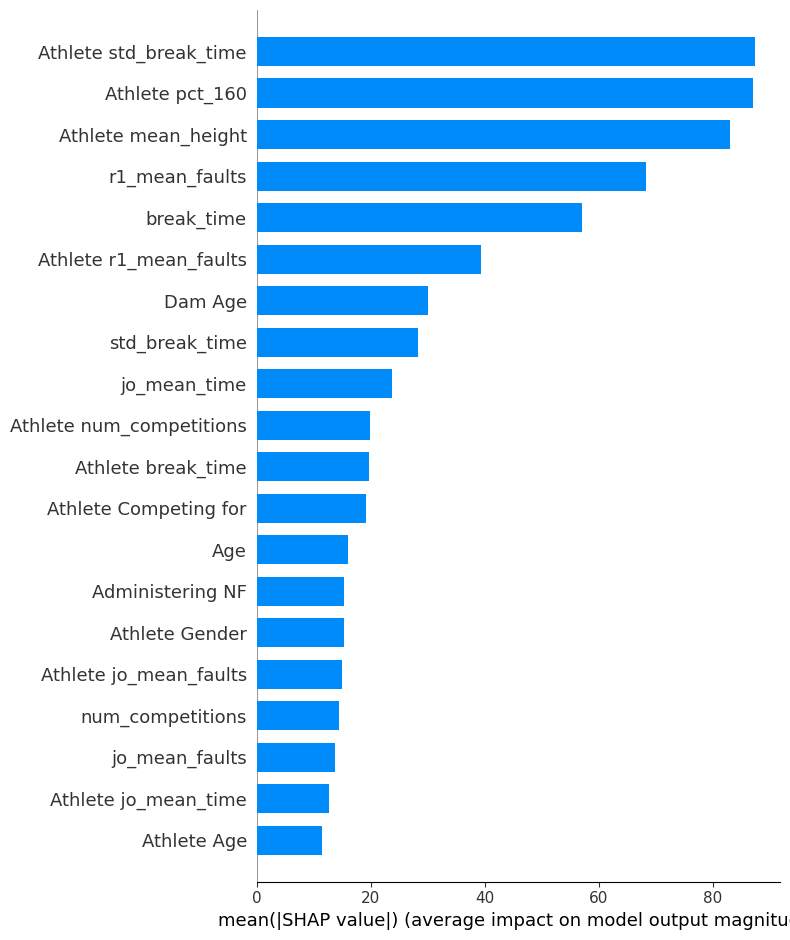

In [78]:
shap.summary_plot(shap_values, X, plot_type='bar')

In [3]:
!jupyter nbconvert --to pdf fei_data_analysis.ipynb

[NbConvertApp] Converting notebook fei_data_analysis.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'fei_data_analysis.ipynb'
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 435, in export_single_notebook
    output, resources = self.exporter.from_filename(notebook_filename, resources=resources)
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\exporters\exporter.py", line 190, in from_filename
    return self.from_file(f, resources=resources, **kw)
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\exporters\exporter.py", line 208, in from_file
    return self.from_notebook_node(nbformat.read(file_stream, as_version=4), resources=resources, **kw)
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\exporters\pdf.py", line 168, in from_notebook_node
    latex, resources = super().from_notebook_node(
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\exporters\latex.